In [ ]:
from scipy import stats
import random
import xgboost as xgb
import math
from sklearn.decomposition import PCA
import osmnx as ox
import networkx as nx
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import scipy.sparse as sp
import warnings
import os


In [ ]:
import seaborn as sns
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import mean_squared_error,r2_score

In [ ]:
# Bike transcation data of 7 months

april=pd.read_csv(r'C:\all others\Study\Study\Master Thesis papers\Dataset\04.csv')
may=pd.read_csv(r'C:\all others\Study\Study\Master Thesis papers\Dataset\05.csv')
june=pd.read_csv(r'C:\all others\Study\Study\Master Thesis papers\Dataset\06.csv')
july=pd.read_csv(r'C:\all others\Study\Study\Master Thesis papers\Dataset\07.csv')
august=pd.read_csv(r'C:\all others\Study\Study\Master Thesis papers\Dataset\08.csv')
september=pd.read_csv(r'C:\all others\Study\Study\Master Thesis papers\Dataset\09.csv')
october=pd.read_csv(r'C:\all others\Study\Study\Master Thesis papers\Dataset\10.csv')


# Testing geographical cluster

In [ ]:
all_months=pd.concat([april,may,june,july,august,september,october])


In [ ]:
all_months=all_months[(all_months['duration'] >= 60) & (all_months['duration'] <= 21600)]

In [ ]:
stations_location = all_months[['end_station_id', 'end_station_latitude', 'end_station_longitude']].drop_duplicates(subset=['end_station_id'])
stations_location.set_index('end_station_id', inplace=True)
stations_location

,end_station_latitude,end_station_longitude
end_station_id,,
789,60.388910,5.333817
157,60.382255,5.332332
644,60.375141,5.338517
36,60.392918,5.323669
794,60.386681,5.330978
...,...,...
3394,60.351311,5.289943
3438,60.349317,5.288594
3436,60.352648,5.298680


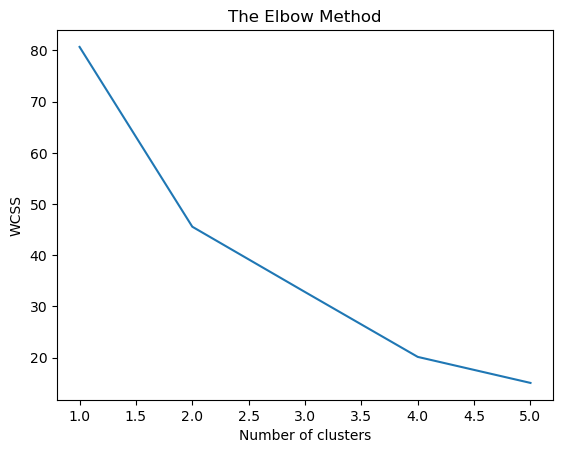

In [ ]:
features = all_months[['end_station_latitude', 'end_station_longitude']]

wcss = []
for i in range(1, 6):
    kmeans_4 = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans_4.fit(features)
    wcss.append(kmeans_4.inertia_)

# Plotting the results onto a line graph to observe 'The elbow'
plt.plot(range(1, 6), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')  # Within-cluster sum of squares
plt.show()


# Perform K-means clustering



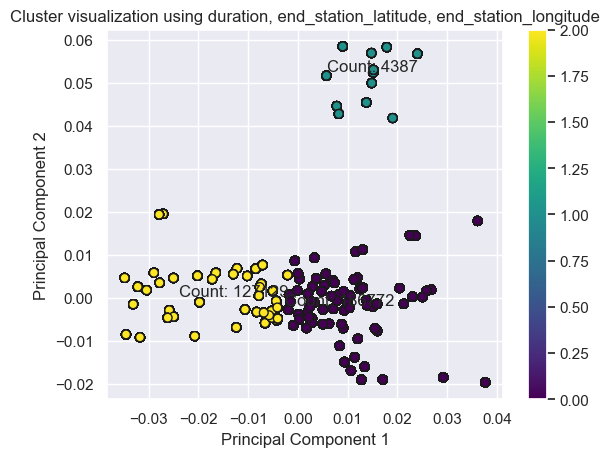

In [ ]:
from collections import Counter
kmeans_4 = KMeans(n_clusters=3)  # Example: choosing 3 clusters
clusters_4 = kmeans_4.fit_predict(features)

# Apply PCA and reduce the data to two principal components for visualization
pca_4 = PCA(n_components=2)
principal_components_4 = pca_4.fit_transform(features)

# Counting the number of points in each cluster
cluster_counts = Counter(clusters_4)

# Plotting the clusters
plt.scatter(principal_components_4[:, 0], principal_components_4[:, 1], c=clusters_4, cmap='viridis', edgecolor='k', s=40)

# Annotating the plot with cluster counts
for cluster_number in range(kmeans_4.n_clusters):
    cluster_center = pca_4.transform([kmeans_4.cluster_centers_[cluster_number]])[0]
    plt.text(cluster_center[0], cluster_center[1], f'Count: {cluster_counts[cluster_number]}', fontsize=12, ha='center')

plt.title('Cluster visualization using duration, end_station_latitude, end_station_longitude')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar()
plt.show()

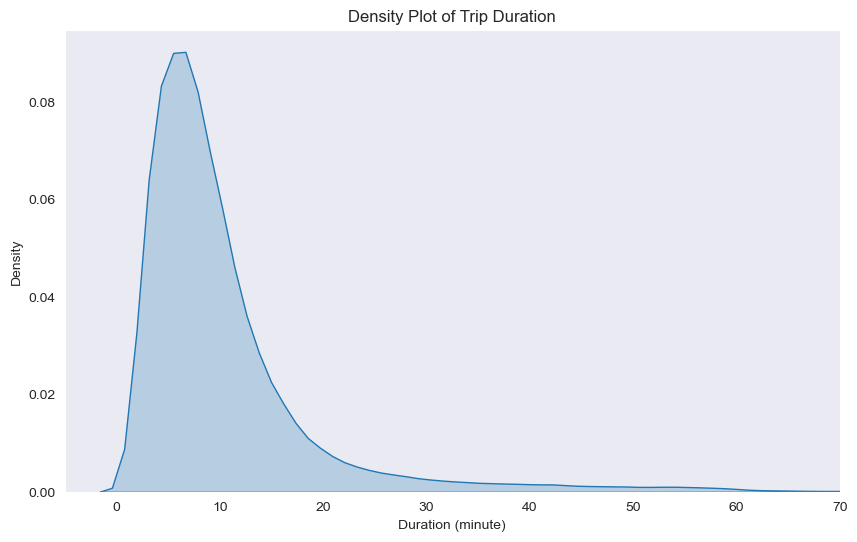

In [ ]:
sns.set_style('dark')
all_months['duration_m']= all_months['duration']/60
plt.figure(figsize=(10, 6))
sns.kdeplot(all_months['duration_m'][(all_months['duration']>=60) & (all_months['duration']<=21600)], fill=True)

plt.title('Density Plot of Trip Duration')
plt.xlabel('Duration (minute)')
plt.ylabel('Density')

# Set the x-axis limits
plt.xlim(-5, 70)  # Replace max_desired_duration with the maximum duration you want to display
plt.savefig('Density plot of trip duration')
plt.show()

In [ ]:
all_months['started_at'] = pd.to_datetime(all_months['started_at'], format='mixed')
all_months["started_date"] = all_months["started_at"].dt.date
all_months['started_hour']=all_months['started_at'].dt.hour
all_months['started_month']=all_months['started_at'].dt.month
all_months["started_day"] = all_months['started_at'].dt.day_name()

In [ ]:

all_months["started_day"]

0        Saturday
1        Saturday
2        Saturday
3        Saturday
4        Saturday
           ...   
31557     Tuesday
31558     Tuesday
31559     Tuesday
31560     Tuesday
31561     Tuesday
Name: started_day, Length: 318284, dtype: object

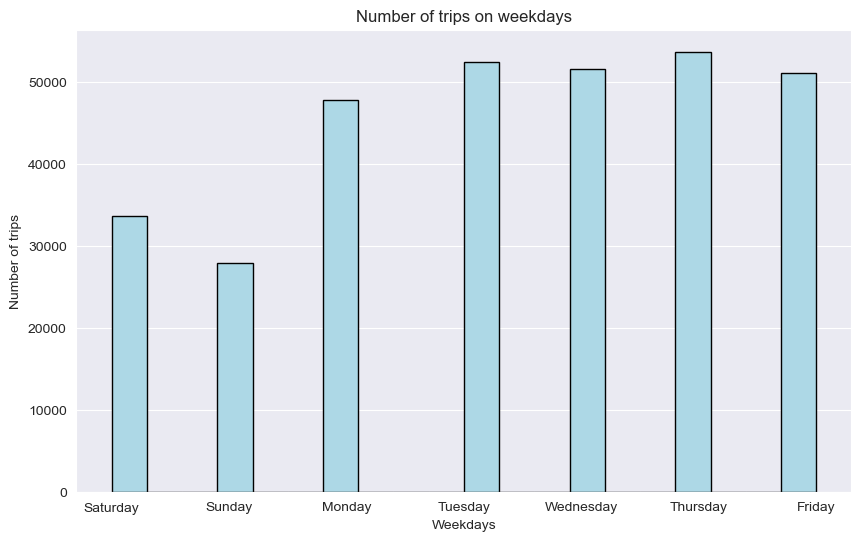

In [ ]:
sns.set_style('dark')
plt.figure(figsize=(10, 6))
plt.hist(all_months['started_day'], bins=20, color='lightblue',edgecolor='black', align='mid')
plt.title('Number of trips on weekdays')
plt.xlabel('Weekdays')
plt.ylabel('Number of trips')
# Set x-ticks to be each month
plt.grid(axis='y',color='white')
plt.savefig('Number of trips on weekdays')
plt.show()

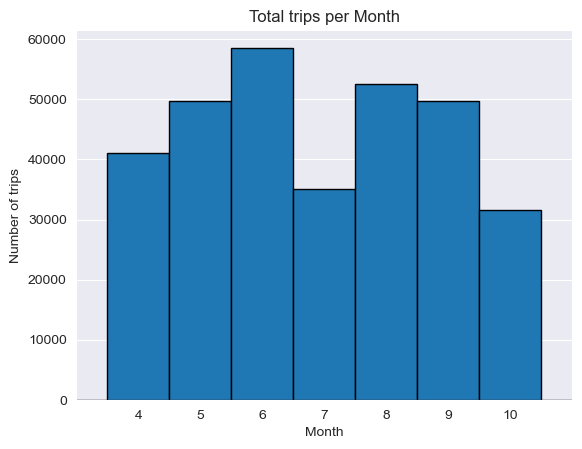

In [ ]:

plt.hist(all_months['started_month'], bins=range(1, 14), edgecolor='black', align='left')
plt.title('Total trips per Month')
plt.xlabel('Month')
plt.ylabel('Number of trips')
plt.xlim(3,11)
plt.xticks(range(4, 11))  # Set x-ticks to be each month
plt.grid(axis='y')
plt.savefig('Bike trips per month')
plt.show()

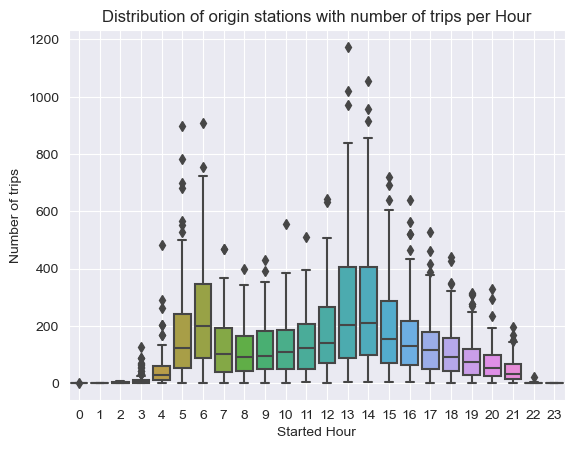

In [ ]:

hourly_counts = all_months.groupby(['start_station_id','started_hour']).size().reset_index(name='counts')

# Create the scatter plot using Seaborn
sns.boxplot(data=hourly_counts, x='started_hour', y='counts')

plt.title('Distribution of origin stations with number of trips per Hour')
plt.xlabel('Started Hour')
plt.ylabel('Number of trips')
plt.grid(True)
plt.savefig('Number of hourly bike trips from stations')
plt.show()

In [ ]:
final_df[final_df['started_hour']==13].iloc[:,11:].sum().sum()

NameError: name 'final_df' is not defined

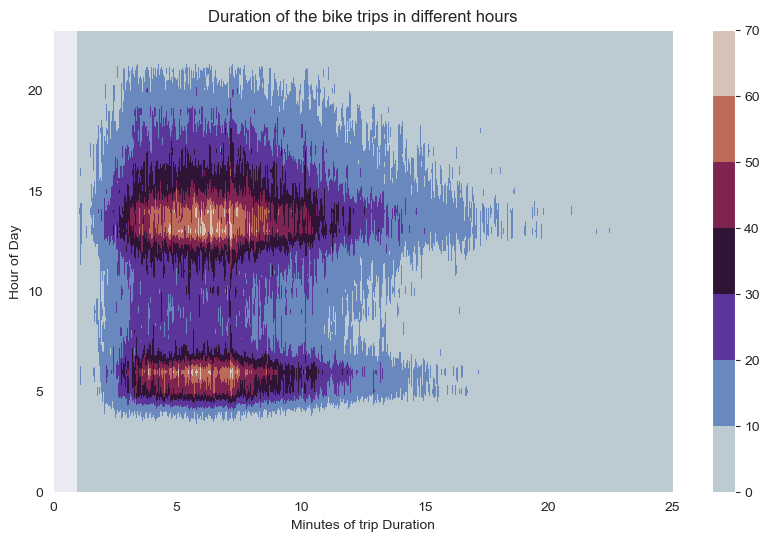

In [ ]:
hourly_counts = all_months.groupby(['duration_m','started_hour']).size().reset_index(name='counts')

pivot_table = hourly_counts.pivot_table(values='counts', index='started_hour', columns='duration_m', fill_value=0)

# Get the unique hours and station IDs
x = pivot_table.index
y = pivot_table.columns

# Create grid coordinates for contour plot
X, Y = np.meshgrid(y, x)

# Get the counts (Z values)
Z = pivot_table.values

# Create contour plot
plt.figure(figsize=(10,6))
cp = plt.contourf(X, Y, Z, cmap='twilight')
plt.colorbar(cp)
plt.title('Duration of the bike trips in different hours')
plt.xlim(0,25)

plt.xlabel('Minutes of trip Duration')
plt.ylabel('Hour of Day')
plt.savefig('Duration of the bike trips in different hours')
plt.show()

In [ ]:
final_df.groupby('month')['Humidity '].mean()

month
4     0.616031
5     0.699937
6     0.647822
7     0.764595
8     0.799039
9     0.850192
10    0.754626
Name: Humidity , dtype: float64

# ----------------------------------------------------------------------------------

In [ ]:
# Weather data of 7 months
weather_df=pd.read_csv(r'C:\all others\Study\Study\Master Thesis papers\Dataset\Bergen Weather data.csv')
weather_df['Date'] = pd.to_datetime(weather_df['Date'])
#weather_df['Time'] = weather_df['Time'].astype(int64)

In [ ]:

def conversion(df: pd.DataFrame)->pd.DataFrame:

    df_1 = df[['started_at', 'start_station_id']][(df['duration']>=60) & (df['duration']<=21600)].copy()

    df_1['started_at'] = pd.to_datetime(df_1['started_at'], format='mixed')
    df_1["started_date"] = df_1["started_at"].dt.date
    df_1["started_time"] = df_1["started_at"].dt.time
    df_1['started_hour']=df_1['started_at'].dt.hour
    #sdf_2 = pd.concat([sdf_2[['started_date', 'started_time']], sdf_2.drop(['started_at','started_date', 'started_time'], axis=1)], axis=1)
    df_1['started_time'] = df_1['started_time'].apply(lambda x: x.strftime('%H:%M:%S'))
    df_1['pickup']=1
    #df_1=df_1[(df_1['duration']>=90) & (df_1['duration']<=21600)]

    # Step 1: Group and Count
    grouped_df = df_1.groupby(['started_date', 'started_hour', 'start_station_id']).size().reset_index(name='pickups')
    grouped_df['started_date'] = pd.to_datetime(grouped_df['started_date'])



    # Step 2: Reset index
    grouped_df.reset_index(drop=True, inplace=True)
    #grouped_df.tail(50)
    # Create an empty MultiIndex with the names 'started_date' and 'started_time'
    columns = ['started_date', 'started_hour'] + list(grouped_df['start_station_id'].unique())
    final_df = pd.DataFrame(columns=columns)
    final_df['started_date']=grouped_df['started_date']
    final_df["started_hour"]=grouped_df["started_hour"]

    # Initialize counts for debugging
    rows_matched = 0
    rows_updated = 0

    # Iterate through each unique date and hour
    for date in grouped_df['started_date'].unique():
        for hour in grouped_df['started_hour'].unique():
            # Filter the DataFrame for that date and hour
            temp_df = grouped_df[(grouped_df['started_date'] == date) & (grouped_df['started_hour'] == hour)]

            # If we have data for that date and hour
            if not temp_df.empty:
                rows_matched += 1
                # Group by 'start_station_id' and sum the 'pickup' values
                summed_values = temp_df.groupby('start_station_id')['pickups'].sum()

            # Iterate through the summed values to update the second DataFrame
                for station_id, pickup_sum in summed_values.items():
                    final_df.loc[(final_df['started_date'] == date) & (final_df['started_hour'] == hour), station_id] = pickup_sum
                    rows_updated += 1
    final_df = final_df.drop_duplicates(subset=['started_date', 'started_hour'])
    final_df.fillna(0, inplace=True)

    return final_df



In [ ]:
def returns_conversion(df: pd.DataFrame) -> pd.DataFrame:

    df_2 = df[['ended_at', 'end_station_id']][(df['duration']>=60) & (df['duration']<=21600)].copy()
    df_2['ended_at'] = pd.to_datetime(df_2['ended_at'], format='mixed')
    #df_2['duration'] = pd.to_timedelta(df_2['duration'], unit='s')
    #df_2["ended_at"] = df_2["started_at"] + df_2["duration"]
    df_2["ended_date"] = df_2["ended_at"].dt.date
    df_2['ended_hour'] = df_2['ended_at'].dt.hour
    df_2['ended_time'] = df_2['ended_at'].dt.time
    df_2['ended_time'] = df_2['ended_time'].apply(lambda x: x.strftime('%H:%M:%S'))
    df_2['returns'] = -1
    #df_2=df_2[(df_2['duration']>=90) & (df_2['duration']<=21600)]
    # Step 1: Group and Count
    grouped_r_df = df_2.groupby(['ended_date', 'ended_hour', 'end_station_id']).size().reset_index(name='returns')
    grouped_r_df['ended_date'] = pd.to_datetime(grouped_r_df['ended_date'])


    grouped_r_df.reset_index(drop=True, inplace=True)

    # Create a dataframe with required columns
    columns = ['ended_date', 'ended_hour'] + list(grouped_r_df['end_station_id'].unique())
    final_r_df = pd.DataFrame(columns=columns)
    final_r_df['ended_date'] = grouped_r_df['ended_date']
    final_r_df["ended_hour"] = grouped_r_df["ended_hour"]

    # Iterate through each unique date and hour
    for date in grouped_r_df['ended_date'].unique():
        for hour in grouped_r_df['ended_hour'].unique():
            temp_df = grouped_r_df[(grouped_r_df['ended_date'] == date) & (grouped_r_df['ended_hour'] == hour)]
            if not temp_df.empty:
                summed_values = temp_df.groupby('end_station_id')['returns'].sum()*-1
                for station_id, return_sum in summed_values.items():
                    final_r_df.loc[(final_r_df['ended_date'] == date) & (final_r_df['ended_hour'] == hour), station_id] = return_sum

    final_r_df.fillna(0, inplace=True)
    final_r_df = final_r_df.drop_duplicates(subset=["ended_date", "ended_hour"])

    return final_r_df


In [ ]:
def returns_conversion(df: pd.DataFrame) -> pd.DataFrame:

    df_2 = df[['ended_at', 'end_station_id']].copy()
    df_2['ended_at'] = pd.to_datetime(df_2['ended_at'], format='mixed')
    #df_2['duration'] = pd.to_timedelta(df_2['duration'], unit='s')
    #df_2["ended_at"] = df_2["started_at"] + df_2["duration"]
    df_2["ended_date"] = df_2["ended_at"].dt.date
    df_2['ended_hour'] = df_2['ended_at'].dt.hour
    df_2['ended_time'] = df_2['ended_at'].dt.time
    df_2['ended_time'] = df_2['ended_time'].apply(lambda x: x.strftime('%H:%M:%S'))
    df_2['returns'] = -1

    # Step 1: Group and Count
    grouped_r_df = df_2.groupby(['ended_date', 'ended_hour', 'end_station_id']).size().reset_index(name='returns')
    grouped_r_df['ended_date'] = pd.to_datetime(grouped_r_df['ended_date'])
    grouped_r_df = grouped_r_df[grouped_r_df[(grouped_r_

    grouped_r_df.reset_index(drop=True, inplace=True)

    # Create a dataframe with required columns
    columns = ['ended_date', 'ended_hour'] + list(grouped_r_df['end_station_id'].unique())
    final_r_df = pd.DataFrame(columns=columns)
    final_r_df['ended_date'] = grouped_r_df['ended_date']
    final_r_df["ended_hour"] = grouped_r_df["ended_hour"]

    # Iterate through each unique date and hour
    for date in grouped_r_df['ended_date'].unique():
        for hour in grouped_r_df['ended_hour'].unique():
            temp_df = grouped_r_df[(grouped_r_df['ended_date'] == date) & (grouped_r_df['ended_hour'] == hour)]
            if not temp_df.empty:
                summed_values = temp_df.groupby('end_station_id')['returns'].sum()*-1
                for station_id, return_sum in summed_values.items():
                    final_r_df.loc[(final_r_df['ended_date'] == date) & (final_r_df['ended_hour'] == hour), station_id] = return_sum

    final_r_df.fillna(0, inplace=True)
    final_r_df = final_r_df.drop_duplicates(subset=["ended_date", "ended_hour"])

    return final_r_df


SyntaxError: '(' was never closed (66382670.py, line 16)

### Pickup & Return conversion

In [ ]:
# pickup
april_df=conversion(april)
may_df=conversion(may)
june_df=conversion(june)
july_df=conversion(july)
august_df=conversion(august)
september_df=conversion(september)
october_df=conversion(october)

# return
april_r_df=returns_conversion(april)
may_r_df=returns_conversion(may)
june_r_df=returns_conversion(june)
july_r_df=returns_conversion(july)
august_r_df=returns_conversion(august)
october_r_df=returns_conversion(october)
september_r_df=returns_conversion(september)

In [ ]:
april_df[22].sum()

231

# Data structuring from April to October 24 12PM

In [ ]:
dataframes = [april_df,may_df, june_df, july_df, august_df, september_df,october_df]

# Using the columns of the first DataFrame (may_df) as a reference
reference_columns = may_df.columns.tolist()

# Check if all DataFrames have the same columns
all_have_same_columns = all(set(df.columns) == set(reference_columns) for df in dataframes)

if all_have_same_columns:
    # Reorder the columns of the DataFrames to match the reference
    for i, df in enumerate(dataframes):
        dataframes[i] = df[reference_columns]
else:
    print("Some DataFrames have missing or additional columns. Cannot proceed with reordering.")

Some DataFrames have missing or additional columns. Cannot proceed with reordering.


In [ ]:
common_columns = set(september_df.columns)

dataframes = [april_df,may_df, june_df, july_df, august_df,  october_df]
for df in dataframes:
    common_columns = common_columns.intersection(set(df.columns))

print(len(common_columns))

116


In [ ]:
common_columns_r = set(september_r_df.columns)

dataframes = [april_r_df,may_r_df,june_r_df, july_r_df, august_r_df, october_r_df]
for df in dataframes:
    common_columns_r = common_columns_r.intersection(set(df.columns))

print(len(common_columns_r))

116


In [ ]:
common_columns=list(common_columns)
april_df_1 = april_df[common_columns]
may_df_1 = may_df[common_columns]
june_df_1 = june_df[common_columns]
july_df_1 = july_df[common_columns]
august_df_1 = august_df[common_columns]
september_df_1 = september_df[common_columns]
october_df_1 = october_df[common_columns]
result_df = pd.concat([april_df_1, may_df_1, june_df_1, july_df_1, august_df_1,september_df_1, october_df_1], ignore_index=True)
# Columns to move to the front
cols_to_front = ['started_date', 'started_hour']

# Remaining columns
remaining_cols = [col for col in result_df.columns if col not in cols_to_front]

# Rearrange columns
result_df = result_df[cols_to_front + remaining_cols]

# adding month column####
result_df['month'] = pd.to_datetime(result_df['started_date']).dt.month

C:\Users\HP EB 820\AppData\Local\Temp\ipykernel_9816\3731674476.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_df['month'] = pd.to_datetime(result_df['started_date']).dt.month


In [ ]:
common_columns_r=list(common_columns_r)
april_r_df_1 = april_r_df[common_columns_r]
may_r_df_1=may_r_df[common_columns_r]
june_r_df_1 = june_r_df[common_columns_r]
july_r_df_1 = july_r_df[common_columns_r]
september_r_df_1=september_r_df[common_columns_r]
august_r_df_1 = august_r_df[common_columns_r]
october_r_df_1 = october_r_df[common_columns_r]
result_r_df = pd.concat([april_r_df_1,may_r_df_1, june_r_df_1, july_r_df_1, august_r_df_1,september_r_df_1, october_r_df_1], ignore_index=True)
# Columns to move to the front
cols_to_front = ['ended_date', 'ended_hour']

# Remaining columns
remaining_cols = [col for col in result_r_df.columns if col not in cols_to_front]

# Rearrange columns
result_r_df = result_r_df[cols_to_front + remaining_cols]

# adding month column####
result_r_df['month'] = pd.to_datetime(result_r_df['ended_date']).dt.month

C:\Users\HP EB 820\AppData\Local\Temp\ipykernel_9816\3836600445.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_r_df['month'] = pd.to_datetime(result_r_df['ended_date']).dt.month


In [ ]:
dfs = [april_df,may_df, june_df, july_df, august_df, september_df,october_df]
df_names = ["april_df","may_df", "june_df", "july_df", "august_df", "september_df","october_df"]

for name, df in zip(df_names, dfs):
    print(f"{name} has {df.shape[1]} columns.")


april_df has 120 columns.
may_df has 123 columns.
june_df has 121 columns.
july_df has 121 columns.
august_df has 122 columns.
september_df has 123 columns.
october_df has 122 columns.


In [ ]:
dfrs = [april_r_df,may_r_df, june_r_df, july_r_df, august_r_df, september_r_df,october_r_df]
dfr_names = ["april_r_df","may_r_df", "june_r_df", "july_r_df", "august_r_df", "september_r_df","october_r_df"]

for name, df in zip(dfr_names, dfrs):
    print(f"{name} has {df.shape[1]} columns.")


april_r_df has 120 columns.
may_r_df has 123 columns.
june_r_df has 121 columns.
july_r_df has 121 columns.
august_r_df has 122 columns.
september_r_df has 123 columns.
october_r_df has 122 columns.


In [ ]:
for name, df in zip(df_names, dfs):
    missing_cols = set(may_df.columns) - set(df.columns)
    if missing_cols:
        print(f"{name} is missing the columns: {missing_cols}")


april_df is missing the columns: {3436, 3437, 3438}
june_df is missing the columns: {3397, 798}
july_df is missing the columns: {1899, 3397, 798}
august_df is missing the columns: {3397, 798}
september_df is missing the columns: {798}
october_df is missing the columns: {1044, 798}


In [ ]:
for name, df in zip(dfr_names, dfrs):
    missing_cols = set(may_r_df.columns) - set(df.columns)
    if missing_cols:
        print(f"{name} is missing the columns: {missing_cols}")

april_r_df is missing the columns: {3436, 3437, 3438}
june_r_df is missing the columns: {3397, 798}
july_r_df is missing the columns: {1899, 3397, 798}
august_r_df is missing the columns: {3397, 798}
september_r_df is missing the columns: {798}
october_r_df is missing the columns: {1044, 798}


# Merging with weather data for pickup and return

In [ ]:
merged_df = result_df.merge(weather_df,
                            left_on=['started_date', 'started_hour'],
                            right_on=['Date', 'Time'],
                            how='left')

# If you want to drop the redundant 'date' and 'hour' columns from the weather dataset:
merged_df.drop(columns=['Date', 'Time'], inplace=True)
merged_df.head(2)

,started_date,started_hour,3,5,7,8,1043,1045,1046,1047,...,Min. temp.,Max temp.,Measured temp.,Precip. mm,Snow depth cm,Wind speed m/s,Strongest gust m/s,Humidity,Weekdays,Weekend
0,2023-04-01,3,0,0,0,0,0,1,0,0,...,0.6,1.2,0.7,0.0,–,0.8,3.4,0.65,0.0,1.0
1,2023-04-01,4,0,0,0,0,0,0,0,0,...,-0.6,0.8,-0.6,0.0,–,1.2,1.8,0.7,0.0,1.0


In [ ]:
merged_r_df = result_r_df.merge(weather_df,
                            left_on=['ended_date', 'ended_hour'],
                            right_on=['Date', 'Time'],
                            how='left')

# If you want to drop the redundant 'date' and 'hour' columns from the weather dataset:
merged_r_df.drop(columns=['Date', 'Time'], inplace=True)
merged_r_df.tail(2)

,ended_date,ended_hour,3,5,7,8,1043,1045,22,1047,...,Min. temp.,Max temp.,Measured temp.,Precip. mm,Snow depth cm,Wind speed m/s,Strongest gust m/s,Humidity,Weekdays,Weekend
4150,2023-10-24,12,0,-1,0,0,-1,-5,0,0,...,6.4,7.9,7.7,0.0,–,0.4,1.0,0.9,1.0,0.0
4151,2023-10-24,13,0,0,0,-1,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
print(len(merged_df))
print(len(merged_r_df))

3982
4152


# Data processing for pickup

In [ ]:
# Identify the initial columns in result_df
initial_columns = result_df.columns.tolist()

# Identify the weather-specific columns
weather_columns = [col for col in merged_df.columns if col not in initial_columns]

# Create the new column order
new_order = initial_columns[:2] +initial_columns[116:117] + weather_columns + initial_columns[2:116]

# Reorder the columns
merged_df_1 = merged_df[new_order]
merged_df_1.drop(columns=["Date__","Weather","Snow depth cm","Weekdays"],inplace=True)

C:\Users\HP EB 820\AppData\Local\Temp\ipykernel_9816\2363637920.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df_1.drop(columns=["Date__","Weather","Snow depth cm","Weekdays"],inplace=True)


In [ ]:
#for column in columns_to_process:

columns_with_weekend = [
    'Min. temp.', 'Max temp.', 'Measured temp.',"Precip. mm",
    'Wind speed m/s', 'Strongest gust m/s','Humidity ' ,'Weekend']
for column in columns_with_weekend:
    merged_df_1[column] = pd.to_numeric(merged_df_1[column], errors='coerce')

C:\Users\HP EB 820\AppData\Local\Temp\ipykernel_9816\1629964108.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df_1[column] = pd.to_numeric(merged_df_1[column], errors='coerce')


In [ ]:
columns_to_process = [
    'Min. temp.', 'Max temp.', 'Measured temp.',"Precip. mm",
    'Wind speed m/s', 'Strongest gust m/s','Humidity ' ,'Weekend']


# Calculating averages based on month and week
averages = merged_df_1.groupby(['month'])[columns_to_process].transform('mean')

# Replacing NaN values with averages for the specific month and week
for column in columns_to_process:
    merged_df_1[column].fillna(averages[column], inplace=True)


C:\Users\HP EB 820\AppData\Local\Temp\ipykernel_9816\3457453308.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df_1[column].fillna(averages[column], inplace=True)


In [ ]:
rows_with_nan_in_min_temp = merged_df_1[merged_df_1['started_date'].isnull()]
rows_with_nan_in_min_temp

,started_date,started_hour,month,Min. temp.,Max temp.,Measured temp.,Precip. mm,Wind speed m/s,Strongest gust m/s,Humidity,...,1892,1893,1894,1895,1896,1897,1898,1900,367,368


In [ ]:
# Checking unique values in columns
for column in columns_to_process:
    print(f"Unique values in {column}:")
    print(merged_df_1[column].unique())

Unique values in Min. temp.:
[ 0.6        -0.6        -0.8        -1.2        -1.5        -1.4
  0.3         4.5         6.          7.4         8.6         9.5
  9.6         9.4         8.7         7.9         6.1         4.8
 -0.3        -0.7        -1.1         1.5         4.3         5.8
  7.7         8.          8.1         8.3         7.2         6.4
  4.6         5.1         4.7         4.4         5.4         5.3
  5.2         6.2         6.8         7.3         7.          6.6
  7.30134875  0.4         3.3         8.4         9.          9.3
  7.6         7.1         5.          3.4         3.7         3.6
  9.7         9.8         6.9         5.7         3.          2.7
  2.2         0.8         2.3         6.3         5.5         4.
  3.5         3.1         1.7         1.3        11.1        11.4
 11.         10.7         8.8         1.8         1.          0.5
  9.1        10.         11.3        11.8        12.5        12.9
 12.6         5.9         6.7         8.9       

# Data processing for return    

In [ ]:
# Identify the initial columns in result_df
initial_columns = result_r_df.columns.tolist()

# Identify the weather-specific columns
weather_columns = [col for col in merged_r_df.columns if col not in initial_columns]

# Create the new column order
new_order = initial_columns[:2] +initial_columns[116:117] + weather_columns + initial_columns[2:116]

# Reorder the columns
merged_r_df_1 = merged_r_df[new_order]
merged_r_df_1.drop(columns=["Date__","Weather","Snow depth cm","Weekdays"],inplace=True)

C:\Users\HP EB 820\AppData\Local\Temp\ipykernel_9816\3785032546.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_r_df_1.drop(columns=["Date__","Weather","Snow depth cm","Weekdays"],inplace=True)


In [ ]:
#for column in columns_to_process:
columns_with_weekend = [
    'Min. temp.', 'Max temp.', 'Measured temp.', 'Precip. mm',
    'Wind speed m/s', 'Strongest gust m/s','Humidity ' ,'Weekend']

for column in columns_with_weekend:
    merged_r_df_1[column] = pd.to_numeric(merged_r_df_1[column], errors='coerce')

C:\Users\HP EB 820\AppData\Local\Temp\ipykernel_9816\2055132181.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_r_df_1[column] = pd.to_numeric(merged_r_df_1[column], errors='coerce')


In [ ]:
columns_to_process = [
    'Min. temp.', 'Max temp.', 'Measured temp.', 'Precip. mm',
    'Wind speed m/s', 'Strongest gust m/s','Humidity ' ,'Weekend']

# Calculating averages based on month and week
averages = merged_r_df_1.groupby(['month'])[columns_to_process].transform('mean')

# Replacing NaN values with averages for the specific month and week
for column in columns_to_process:
    merged_r_df_1[column].fillna(averages[column], inplace=True)

C:\Users\HP EB 820\AppData\Local\Temp\ipykernel_9816\3907030097.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_r_df_1[column].fillna(averages[column], inplace=True)


In [ ]:
merged_r_df_1.head(2)

,ended_date,ended_hour,month,Min. temp.,Max temp.,Measured temp.,Precip. mm,Wind speed m/s,Strongest gust m/s,Humidity,...,1893,1894,1895,1896,1897,1898,1900,367,368,811
0,2023-04-01,4,4,-0.6,0.8,-0.6,0.0,1.2,1.8,0.70,...,0,0,0,0,0,0,0,0,-1,0
1,2023-04-01,5,4,-0.8,-0.2,-0.4,0.0,1.4,2.4,0.71,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
zero_count = (final_df == 0).sum()
print(zero_count)

NameError: name 'final_df' is not defined

# Descriptive analysis

In [ ]:
len(merged_df_1)

3982

In [ ]:
len(merged_r_df_1)

4152

#  <span style="color: black; font-family: Oswald ;">*Clustering for Pickup Station Selection*</span>

In [ ]:
# First, ensure that the stations columns are in a long format
c_df=result_df.drop(columns=["started_date","month"])
long_format_df = c_df.melt(id_vars=['started_hour'],
                                value_vars=result_df.columns[2:116],
                                var_name='Stations',
                                value_name='Values')

long_format_df.head(2)


,started_hour,Stations,Values
0,3,3,0
1,4,3,0


In [ ]:
# First, ensure that the stations columns are in a long format
c_r_df=result_r_df.drop(columns=["ended_date","month"])
long_format_r_df = c_r_df.melt(id_vars=['ended_hour'],
                                value_vars=result_r_df.columns[2:116],
                                var_name='Stations',
                                value_name='Values')

long_format_r_df.head(2)

,ended_hour,Stations,Values
0,4,3,0
1,5,3,0


In [ ]:
# Create an empty DataFrame with unique stations as index and hours as columns
unique_stations = long_format_df['Stations'].unique()
unique_hours = long_format_df['started_hour'].unique()
cluster_df = pd.DataFrame(index=unique_stations, columns=unique_hours).fillna(0)

# Populate the DataFrame
for _, row in long_format_df.iterrows():
    station = row['Stations']
    hour = row['started_hour']
    value = row['Values']
    cluster_df.at[station, hour] += value

# Sort the DataFrame for better clarity
cluster_df.sort_index(axis=1, inplace=True)

print(cluster_df)



      0   1   2   3    4    5    6    7    8    9   ...   14   15   16   17  \
3      1   0   0  57   83  195  312  260  199  175  ...  398  355  336  281   
5      0   0   0   1   28  220  291  225  187  185  ...  478  221  196  138   
7      0   0   0   4   34   93  179   91  111   88  ...  173  158  145  149   
8      0   0   0   0    5   74   98   57   51   83  ...  254   91   66   49   
1043   0   0   0   1  102  304  378  202  114  118  ...  249  159  160  111   
...   ..  ..  ..  ..  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
1897   0   0   0   2    9   22   23    9   16   21  ...   37   40   36   33   
1898   0   0   0   5   12   62   30   12    5   10  ...   19   34   21   25   
1900   0   0   0   2   12   23   53   92   65   57  ...  120   92   82   71   
367    0   0   0   2    3   55   50   23   15   14  ...   63   32   33   30   
368    0   0   0  16  170  437  555  210  207  250  ...  728  533  424  334   

       18   19   20   21  22  23  
3     263  208  

In [ ]:
# Create an empty DataFrame with unique stations as index and hours as columns
unique_stations = long_format_r_df['Stations'].unique()
unique_hours = long_format_r_df['ended_hour'].unique()
cluster_r_df = pd.DataFrame(index=unique_stations, columns=unique_hours).fillna(0)

# Populate the DataFrame
for _, row in long_format_r_df.iterrows():
    station = row['Stations']
    hour = row['ended_hour']
    value = row['Values']
    cluster_r_df.at[station, hour] += value

# Sort the DataFrame for better clarity
cluster_r_df.sort_index(axis=1, inplace=True)
print(cluster_r_df)

      0   1   2   3    4    5    6    7    8    9   ...   14   15   16   17  \
3      0   0   0  -8  -10 -109 -380 -249 -225 -250  ... -463 -379 -362 -333   
5     -1   0   0 -18 -202 -622 -533 -204 -135 -112  ... -338 -262 -239 -201   
7      0   0   0   0  -11  -28 -141 -118 -105 -132  ... -212 -262 -190 -184   
8      0   0   0  -1  -74 -110 -128  -30  -46  -57  ...  -31  -39  -28  -29   
1043  -1   0   0  -1  -73 -144 -343 -162  -71  -96  ... -247 -174 -160 -133   
...   ..  ..  ..  ..  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
1898   0   0   0   0   -3   -4  -18   -6   -5  -10  ...  -86  -29  -15  -17   
1900   0   0   0   0   -1  -29  -95  -46  -42  -52  ...  -91  -87 -109  -76   
367    0   0   0   0  -33  -18  -18  -21  -17  -23  ...  -29  -24  -15  -14   
368    0   0   0  -9  -77 -268 -419 -349 -300 -345  ... -768 -568 -487 -401   
811    0   0   0  -3   -7   -7   -9  -11  -10  -21  ...  -64  -44  -49  -46   

       18   19   20   21  22  23  
3    -280 -220 -

In [ ]:
c_copy=cluster_df.copy()
c_r_copy=(cluster_r_df.copy())#*-1


In [ ]:
#c_copy[c_copy == 0] = 0.5
#c_r_copy[c_r_copy == 0] = 5000
c_copy.sort_index( inplace=True)
c_r_copy.sort_index( inplace=True)
# Recalculating the ratio dataframe
ratio_df_updated = c_copy + c_r_copy

# Displaying the first few rows of the updated ratio dataframe
ratio_df_updated = ratio_df_updated.merge(stations_location[['end_station_latitude', 'end_station_longitude']],
                                    left_index=True,
                                    right_index=True,
                                    how='left')
print(ratio_df_updated)

      0  1  2   3    4    5    6   7   8   9  ...  16  17  18  19  20  21  22  \
3     1  0  0  49   73   86  -68  11 -26 -75  ... -26 -52 -17 -12 -20  14 -17   
5    -1  0  0 -17 -174 -402 -242  21  52  73  ... -43 -63 -70 -43 -23 -13 -19   
7     0  0  0   4   23   65   38 -27   6 -44  ... -45 -35 -50 -20  30  81 -12   
8     0  0  0  -1  -69  -36  -30  27   5  26  ...  38  20  29  65  91   5  -3   
22    0  0  0   6    7   -5  211  73   6 -17  ... -70 -59 -30 -11  14  -2  -6   
...  .. .. ..  ..  ...  ...  ...  ..  ..  ..  ...  ..  ..  ..  ..  ..  ..  ..   
3395  0  0  0   0    3    9   59  28  22  50  ...  27  36  13  12   3   4   0   
3396  0  0  0 -14   22  208  142  46  17  55  ...  45  76  28  62  -2   3  -9   
3398  0  0  0   1    2   17   15   5  -2  23  ...  11   6  -8 -19 -11  -4   0   
3399  0  0  0   0    1    0    0  -3  -3   3  ...   9   0   1   8   0  -1   0   
3400  0  0  0   0    2    0   -3  15   4   3  ...  -9   5   0  -5   2   1   0   

      23  end_station_latit

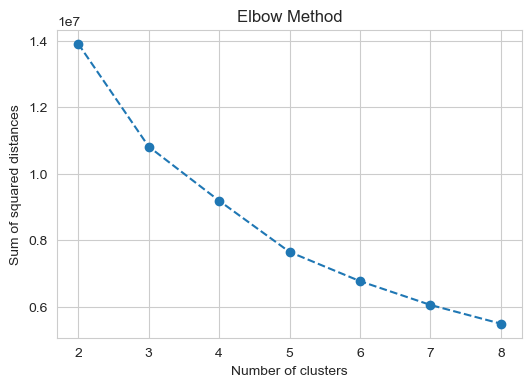

For n_clusters = 2, silhouette score is 0.5860
For n_clusters = 3, silhouette score is 0.4355
For n_clusters = 4, silhouette score is 0.4223
For n_clusters = 5, silhouette score is 0.4217
For n_clusters = 6, silhouette score is 0.2345
For n_clusters = 7, silhouette score is 0.2439
For n_clusters = 8, silhouette score is 0.2540


In [ ]:
sns.set_style('whitegrid')
# Set environment variable
os.environ['OMP_NUM_THREADS'] = '1'

# Suppress warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)



# Prepare the data
X = ratio_df_updated.drop('cluster', axis=1, errors='ignore').values  # Ensure 'cluster' column is not in our X data

# Calculate sum of squared distances and silhouette scores
ssd = []
sil_scores = []  # List to store silhouette scores
range_clusters = range(2,9)  # Starting from 2 because silhouette score requires at least 2 clusters to compute

for num_clusters in range_clusters:
    kmeans = KMeans(n_clusters=num_clusters, n_init=10, random_state=2)
    kmeans.fit(X)
    ssd.append(kmeans.inertia_)

    # Compute silhouette score
    cluster_labels = kmeans.predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    sil_scores.append(silhouette_avg)

# Plotting the elbow
plt.figure(figsize=(6,4))
plt.plot(range_clusters, ssd, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances')
plt.grid(True)
plt.savefig('Elbow Method.png')
plt.show()

# Print silhouette scores
for num_clusters, score in zip(range_clusters, sil_scores):
    print(f"For n_clusters = {num_clusters}, silhouette score is {score:.4f}")

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=2)
cluster_labels = kmeans.fit_predict(X)

# Add the cluster labels to cluster_df
c_copy['cluster'] = cluster_labels
c_r_copy['cluster'] = cluster_labels
# Create a dictionary with cluster numbers as keys and lists of station names as values
clusters_dict = {}
clusters_r_dict={}
for station, cluster in zip(c_copy.index, c_copy['cluster']):
    if cluster not in clusters_dict:
        clusters_dict[cluster] = []
    clusters_dict[cluster].append(station)
for station, cluster in zip(c_r_copy.index, c_r_copy['cluster']):
    if cluster not in clusters_r_dict:
        clusters_r_dict[cluster] = []
    clusters_r_dict[cluster].append(station)

# Print the clusters and their assigned stations
for cluster, stations in clusters_dict.items():
    print(f"Cluster {cluster}: {stations}\n")



Cluster 0: [3, 7, 8, 22, 33, 34, 36, 49, 58, 69, 70, 82, 83, 98, 116, 117, 131, 132, 140, 150, 151, 156, 212, 215, 216, 217, 219, 223, 298, 367, 368, 638, 639, 642, 645, 646, 788, 789, 790, 791, 792, 793, 795, 796, 797, 799, 800, 802, 803, 804, 806, 809, 811, 812, 815, 816, 817, 818, 1043, 1046, 1047, 1048, 1816, 1887, 1888, 1889, 1890, 1891, 1892, 1893, 1894, 1895, 1896, 1897, 1898, 1900, 2314, 2321, 2336, 2338, 2346, 2352, 3391, 3392, 3393, 3394, 3395, 3396, 3398, 3399, 3400]

Cluster 2: [5, 75, 87, 138, 157, 214, 301, 641, 794, 2313, 2322]

Cluster 1: [24, 220, 221, 222, 640, 644, 807, 808, 810, 814, 819, 1045]



In [ ]:
Cluster 1: [3, 7, 8, 22, 33, 34, 36, 49, 58, 69, 70, 82, 83, 98, 116, 117, 131, 132, 140, 150, 151, 156, 212, 215, 216, 217, 219, 223, 298, 367, 368, 638, 639, 642, 644, 645, 646, 788, 789, 790, 791, 792, 793, 795, 796, 797, 799, 800, 802, 803, 804, 806, 809, 810, 811, 812, 815, 816, 817, 818, 1043, 1046, 1047, 1048, 1816, 1887, 1888, 1889, 1890, 1891, 1892, 1893, 1894, 1895, 1896, 1897, 1898, 1900, 2314, 2321, 2336, 2338, 2346, 2352, 3391, 3392, 3393, 3394, 3395, 3396, 3398, 3399, 3400]

Cluster 2: [5, 75, 87, 138, 157, 214, 301, 641, 794, 2313, 2322]

Cluster 0: [24, 220, 221, 222, 640, 807, 808, 814, 819, 1045]

In [ ]:
print(clusters_dict[2])
print(clusters_r_dict[2])

[5, 75, 87, 138, 157, 214, 301, 641, 794, 2313, 2322]
[5, 75, 87, 138, 157, 214, 301, 641, 794, 2313, 2322]


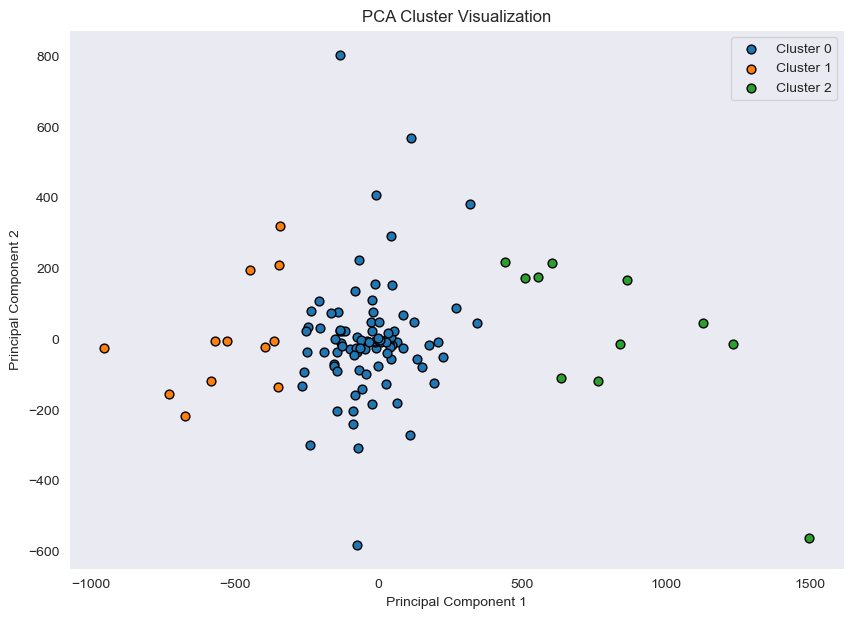

In [ ]:
# Perform PCA to reduce the dimensions to 2 for visualization

sns.set_style("dark")
pca = PCA(n_components=2)
X_cluster_reduced = pca.fit_transform(X)

# Create a DataFrame with the PCA results
X_cluster_reduced_df = pd.DataFrame(X_cluster_reduced, columns=['PC1', 'PC2'])

# Add the cluster labels to the DataFrame
X_cluster_reduced_df['cluster'] = cluster_labels


plt.figure(figsize=(10, 7))
for cluster in np.unique(X_cluster_reduced_df['cluster']):
    cluster_data = X_cluster_reduced_df[X_cluster_reduced_df['cluster'] == cluster]
    plt.scatter(cluster_data['PC1'], cluster_data['PC2'], label=f'Cluster {cluster}',cmap='viridis', edgecolor='k', s=40)
plt.legend()
plt.title('PCA Cluster Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

plt.savefig('Cluster of bike stations.png')
plt.show()

#  <span style="color: black; font-family: Oswald ;">*Clustering for Return Station Selection*</span>

In [ ]:
ratio_df_updated[14].idxmax()

2322

In [ ]:
cluster_r_df.to_csv(r'C:\all others\Study\Study\Master Thesis papers\Dataset\cluster_r.csv', index=False)

# Average for station Selection

In [ ]:
averages.mean()

0.7004626739617376

In [ ]:

# Adjust pandas display options to show all columns
pd.set_option('display.max_columns', None)

# Exclude the first two columns
selected_columns = result_df.columns[2:115]

# Calculate the average for each column
averages = result_df[selected_columns].mean()
total_sum=result_df[selected_columns].sum()
joined=pd.concat([total_sum,averages],axis=1,keys=["Summation","Average"])
joined["Difference from Total Summation"]=joined["Summation"].apply(lambda x: total_sum.mean()-x)
joined["z-score"]=stats.zscore(joined["Summation"])
joined.head(20)

joined[(joined["z-score"]<1.8) & (joined["z-score"]>-1.8)]

,Summation,Average,Difference from Total Summation,z-score
3,2559,1.061826,-870.884956,0.717066
5,2399,0.995436,-710.884956,0.585325
7,1390,0.576763,298.115044,-0.245461
8,1298,0.538589,390.115044,-0.321211
1043,1552,0.643983,136.115044,-0.112074
...,...,...,...,...
1896,356,0.147718,1332.115044,-1.096831
1897,225,0.093361,1463.115044,-1.204693
1898,218,0.090456,1470.115044,-1.210457
1900,696,0.288797,992.115044,-0.816883


In [ ]:
pd.set_option('display.max_rows', None)
filtered_df = joined[joined.index.isin( clusters_dict[0])]
print(filtered_df)


NameError: name 'joined' is not defined

#  <span style="color: black; font-family: Oswald ;">*Data processing of the selective stations for predictive model*</span>

In [ ]:
#Pickup
sample_sizes={2:11}
cluster_columns=[]
# Adding to empty list
for c ,s in sample_sizes.items():
    cluster_columns.extend(random.sample(clusters_dict[c],s))


#cluster_columns = [clusters_dict[2][1]]

b=merged_df_1.columns.tolist()[:11]+cluster_columns
final_df=merged_df_1[b]
final_df['days'] = final_df['started_date'].dt.day


# Reorder the columns to place 'day_number' as the second column
cols = final_df.columns.tolist()
cols.insert(1, cols.pop(cols.index('days')))

final_df = final_df[cols]
#final_df = final_df.iloc[7:]
# Display the first 5 rows
final_df.head(5)

C:\Users\HP EB 820\AppData\Local\Temp\ipykernel_9816\711220538.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['days'] = final_df['started_date'].dt.day


,started_date,days,started_hour,month,Min. temp.,Max temp.,Measured temp.,Precip. mm,Wind speed m/s,Strongest gust m/s,...,2322,214,157,301,87,75,2313,5,794,138
0,2023-04-01,1,3,4,0.6,1.2,0.7,0.0,0.8,3.4,...,0,0,0,0,0,0,0,0,0,0
1,2023-04-01,1,4,4,-0.6,0.8,-0.6,0.0,1.2,1.8,...,0,0,0,0,0,0,0,0,1,0
2,2023-04-01,1,5,4,-0.8,-0.2,-0.4,0.0,1.4,2.4,...,0,0,0,0,0,0,0,1,0,0
3,2023-04-01,1,6,4,-0.8,-0.2,-0.7,0.0,0.6,1.8,...,0,0,0,0,0,0,0,0,0,0
4,2023-04-01,1,7,4,-1.2,-0.6,-1.2,0.0,1.3,1.7,...,0,0,1,1,1,0,0,0,0,0


In [ ]:
print(clusters_r_dict[2])
print(clusters_dict[2])

[5, 75, 87, 138, 157, 214, 301, 641, 794, 2313, 2322]
[5, 75, 87, 138, 157, 214, 301, 641, 794, 2313, 2322]


In [ ]:
# Return
sample_sizes_r={2:11}
cluster_columns_r=[]
# Adding to empty list
for c ,s in sample_sizes_r.items():
    cluster_columns_r.extend(random.sample(clusters_r_dict[c],s))


b=merged_r_df_1.columns.tolist()[:11]+cluster_columns_r
final_r_df=merged_r_df_1[b]
final_r_df['days'] = final_r_df['ended_date'].dt.day


# Reorder the columns to place 'day_number' as the second column
cols = final_r_df.columns.tolist()
cols.insert(1, cols.pop(cols.index('days')))

final_r_df = final_r_df[cols]


# Display the first 5 rows
final_r_df.head(5)

C:\Users\HP EB 820\AppData\Local\Temp\ipykernel_9816\1486614720.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_r_df['days'] = final_r_df['ended_date'].dt.day


,ended_date,days,ended_hour,month,Min. temp.,Max temp.,Measured temp.,Precip. mm,Wind speed m/s,Strongest gust m/s,...,2322,2313,75,157,301,214,138,5,794,87
0,2023-04-01,1,4,4,-0.6,0.8,-0.6,0.0,1.2,1.8,...,0,0,0,-1,0,0,0,0,-1,-1
1,2023-04-01,1,5,4,-0.8,-0.2,-0.4,0.0,1.4,2.4,...,0,0,0,-1,0,0,0,0,0,-2
2,2023-04-01,1,6,4,-0.8,-0.2,-0.7,0.0,0.6,1.8,...,0,-1,0,0,-1,-1,0,-1,0,0
3,2023-04-01,1,7,4,-1.2,-0.6,-1.2,0.0,1.3,1.7,...,-1,-1,-1,-1,-1,-1,0,0,0,0
4,2023-04-01,1,8,4,-1.5,-0.9,-1.2,0.0,0.7,1.5,...,0,0,-2,0,-2,-2,-1,0,-2,-2


In [ ]:
# Define the number of samples to pick from each cluster
'''sample_sizes_ts = {1: 4, 2: 4}  # 5 values from cluster 1 and 5 from cluster 2
cluster_columns_ts = []

# Adding to the list from each cluster based on sample sizes
for cluster_id_ts, sample_size_ts in sample_sizes_ts.items():
    cluster_columns_ts.extend(random.sample(clusters_dict[cluster_id_ts], sample_size_ts))'''
cluster_columns_ts=[214, 138, 2313, 794,1045,640, 808, 819]

# Assuming 'merged_df_1_ts' is your DataFrame and 'clusters_dict' contains your clusters
b_ts = merged_df_1.columns.tolist()[:11] + cluster_columns_ts
b_ts_r=merged_r_df_1.columns.tolist()[:11] + cluster_columns_ts
final_df_ts = merged_df_1[b_ts]
final_r_df_ts = merged_r_df_1[b_ts_r]
final_df_ts['days_ts'] = final_df_ts['started_date'].dt.day
final_r_df_ts['days_ts'] = final_r_df_ts['ended_date'].dt.day

# Reorder the columns to place 'days_ts' as the second column
cols_ts = final_df_ts.columns.tolist()
cols_ts.insert(1, cols_ts.pop(cols_ts.index('days_ts')))
final_df_ts = final_df_ts[cols_ts]
##
cols_ts_r = final_r_df_ts.columns.tolist()
cols_ts_r.insert(1, cols_ts_r.pop(cols_ts_r.index('days_ts')))
final_r_df_ts = final_r_df_ts[cols_ts_r]

# Display the first 5 rows
final_r_df_ts.head(5)

C:\Users\HP EB 820\AppData\Local\Temp\ipykernel_9816\330101949.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df_ts['days_ts'] = final_df_ts['started_date'].dt.day
C:\Users\HP EB 820\AppData\Local\Temp\ipykernel_9816\330101949.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_r_df_ts['days_ts'] = final_r_df_ts['ended_date'].dt.day


,ended_date,days_ts,ended_hour,month,Min. temp.,Max temp.,Measured temp.,Precip. mm,Wind speed m/s,Strongest gust m/s,Humidity,Weekend,214,138,2313,794,1045,640,808,819
0,2023-04-01,1,4,4,-0.6,0.8,-0.6,0.0,1.2,1.8,0.70,1.0,0,0,0,-1,0,0,0,0
1,2023-04-01,1,5,4,-0.8,-0.2,-0.4,0.0,1.4,2.4,0.71,1.0,0,0,0,0,0,0,0,0
2,2023-04-01,1,6,4,-0.8,-0.2,-0.7,0.0,0.6,1.8,0.72,1.0,-1,0,-1,0,0,0,0,0
3,2023-04-01,1,7,4,-1.2,-0.6,-1.2,0.0,1.3,1.7,0.75,1.0,-1,0,-1,0,0,0,0,0
4,2023-04-01,1,8,4,-1.5,-0.9,-1.2,0.0,0.7,1.5,0.77,1.0,-2,-1,0,-2,-1,0,0,0


In [ ]:
final_r_df_ts.head(2)

,ended_date,days_ts,ended_hour,month,Min. temp.,Max temp.,Measured temp.,Precip. mm,Wind speed m/s,Strongest gust m/s,Humidity,Weekend,644,24,810,819,5,2313,87,157
0,2023-04-01,1,4,4,-0.6,0.8,-0.6,0.0,1.2,1.8,0.70,1.0,-1,0,0,0,0,0,-1,-1
1,2023-04-01,1,5,4,-0.8,-0.2,-0.4,0.0,1.4,2.4,0.71,1.0,-1,0,0,0,0,0,-2,-1


In [ ]:
with pd.option_context('display.max_rows', None):
    null_counts = merged_df_1.isnull().sum()
    print(null_counts)


started_date          0
started_hour          0
month                 0
Min. temp.            0
Max temp.             0
Measured temp.        0
Precip. mm            0
Wind speed m/s        0
Strongest gust m/s    0
Humidity              0
Weekend               0
3                     0
5                     0
7                     0
8                     0
1043                  0
1045                  0
1046                  0
1047                  0
1048                  0
22                    0
24                    0
33                    0
34                    0
36                    0
49                    0
58                    0
69                    0
70                    0
75                    0
82                    0
83                    0
87                    0
98                    0
116                   0
117                   0
638                   0
639                   0
640                   0
641                   0
642                   0
131             

In [ ]:
final_df.set_index('started_date', inplace=True)
final_r_df.set_index('ended_date', inplace=True)

In [ ]:
final_df_ts.set_index('started_date', inplace=True)
final_r_df_ts.set_index('ended_date', inplace=True)

In [ ]:
len(final_r_df_ts)

4152

In [ ]:
final_r_df['month'].unique()

array([ 4,  5,  6,  7,  8,  9, 10])

# Descriptive analysis for selective stations in cluster 2

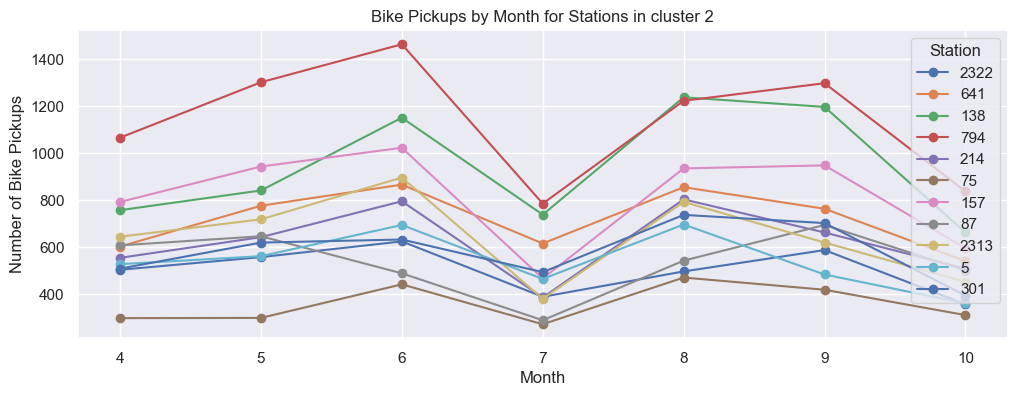

In [ ]:
monthly_sums = final_df.groupby('month').sum()
sns.set_style("darkgrid")
plt.figure(figsize=(12, 4))

for station in monthly_sums.columns[10:]:
    plt.plot(monthly_sums.index, monthly_sums[station], marker='o', label=station)

plt.xlabel('Month')
plt.ylabel('Number of Bike Pickups')
plt.title('Bike Pickups by Month for Stations in cluster 2')
plt.xticks(monthly_sums.index)

plt.legend(title='Station')
plt.show()

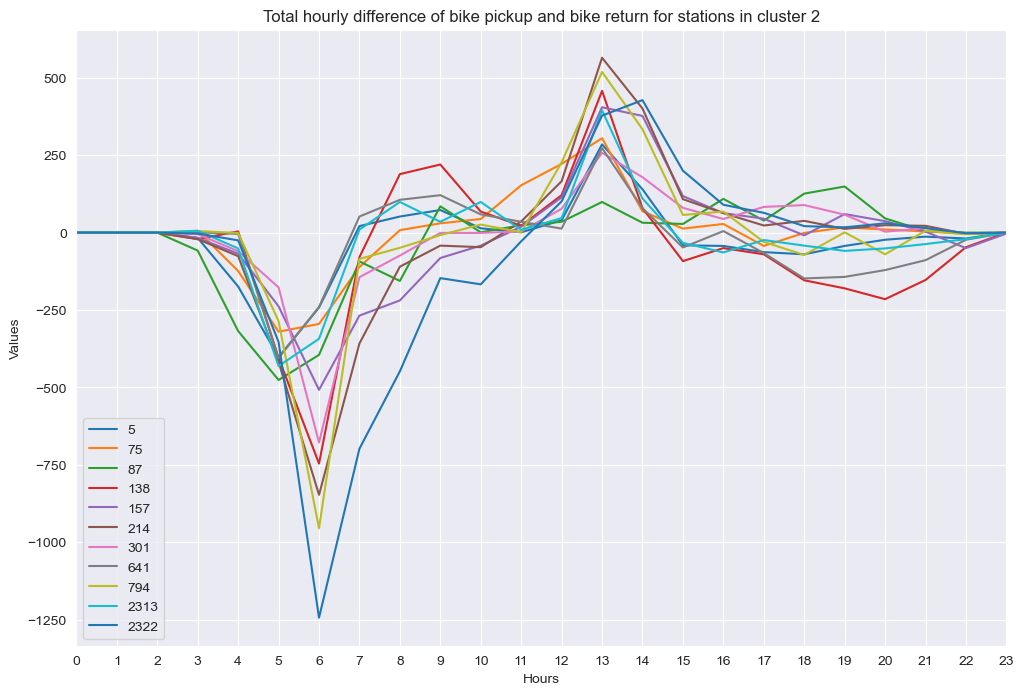

In [ ]:
sns.set_style("darkgrid")
selected_rows = ratio_df_updated.loc[[5, 75, 87, 138, 157, 214, 301, 641, 794, 2313, 2322]].iloc[:, :-2]

# Prepare the plot
plt.figure(figsize=(12, 8))

# Iterate over each row and plot a line for each
for index, row in selected_rows.iterrows():
    plt.plot(row.index, row.values, label=f'{index}')

# Adding labels and title
ax = plt.gca()  # Get current axis
ax.xaxis.set_major_locator(MultipleLocator(1))
plt.xlabel('Hours')
plt.ylabel('Values')
plt.xlim(0,23)
plt.title('Total hourly difference of bike pickup and bike return for stations in cluster 2')
plt.legend()
plt.savefig('Cluster 2')
# Show the plot
plt.show()

Moxy Hotellet- 5
Akvariet-75
AdO arena-87
C. Sundts gate-138
Florida Bybanestopp-157
Nygårdsporten-214
Lars Hilles-301
Krohnviken-641
St. Jakobs Plass-794
Solheimsviken-2313
Høyteknologisenteret-2322

24- Studentboligene
220- Møllendalsplass
221-Sandvikstorget
222-Sandviken Brygge
640 -Damsgårdsveien
807 -Dreggsallmenningen Nord
808 -Damsgårdsveien 71
814 -Nykirken
819 -Thormøhlens gate
1045-Damsgårdsveien 2

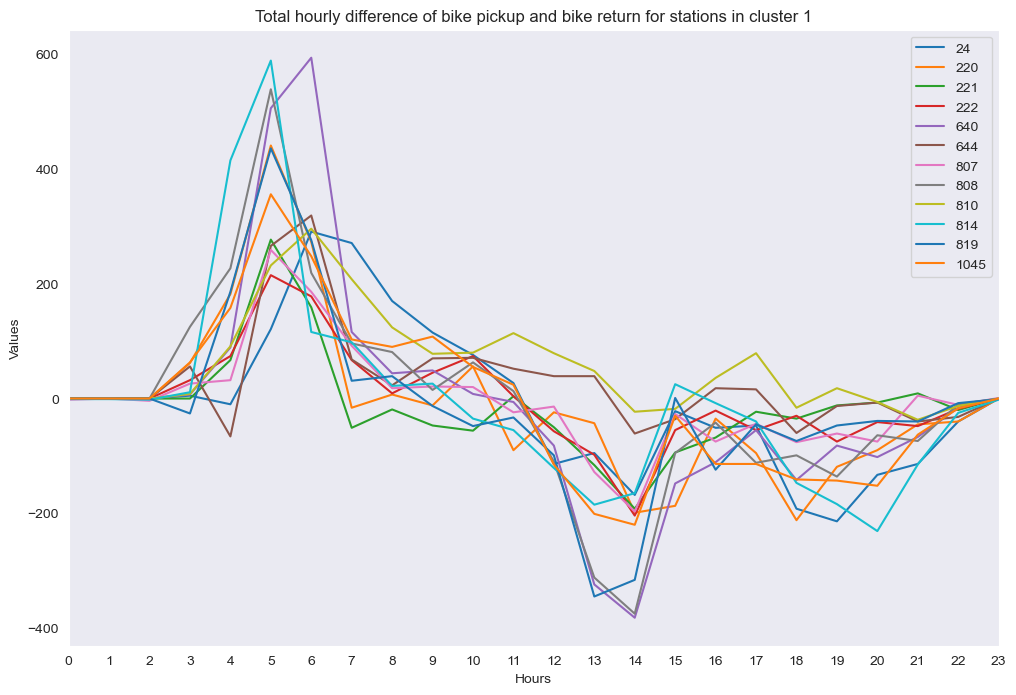

In [ ]:
selected_rows = ratio_df_updated.loc[[24, 220, 221, 222, 640, 644, 807, 808, 810, 814, 819, 1045]].iloc[:, :-2]

# Prepare the plot
plt.figure(figsize=(12, 8))

# Iterate over each row and plot a line for each
for index, row in selected_rows.iterrows():
    plt.plot(row.index, row.values, label=f'{index}')

# Adding labels and title
ax = plt.gca()  # Get current axis
ax.xaxis.set_major_locator(MultipleLocator(1))
plt.xlabel('Hours')
plt.ylabel('Values')
plt.xlim(0,23)
plt.title('Total hourly difference of bike pickup and bike return for stations in cluster 1')
plt.legend()
plt.savefig('Cluster 1')
# Show the plot
plt.show()

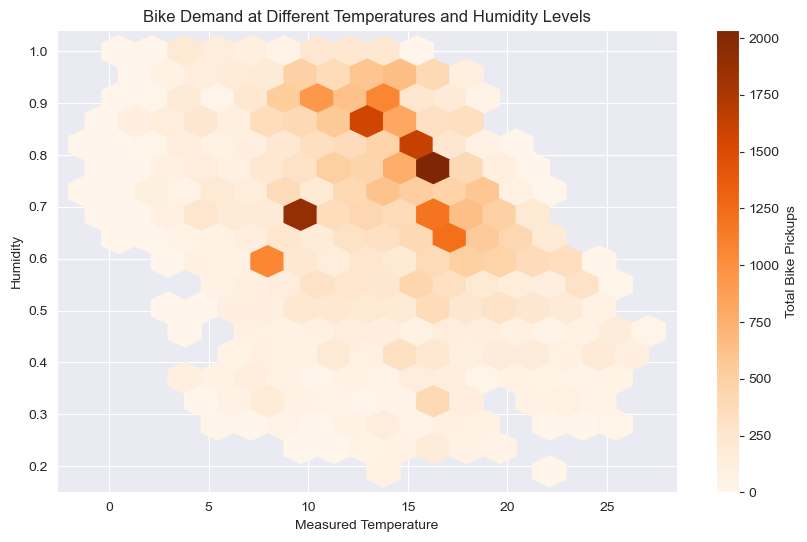

In [ ]:
# Group by 'Measured temp.' and 'Humidity', then sum the bike pickups
gdf = final_df.groupby(['Measured temp.', 'Humidity '])[final_df.columns[11:]].sum()

# Sum across all stations for each group
gdf['Total Pickups'] = gdf.sum(axis=1)

# Reset the index to use in the plot
gdf_reset = gdf.reset_index()

# Plotting the hexbin plot
plt.figure(figsize=(10, 6))
plt.hexbin(gdf_reset['Measured temp.'], gdf_reset['Humidity '],
           C=gdf_reset['Total Pickups'], gridsize=17, cmap='Oranges', reduce_C_function=np.sum)

plt.colorbar(label='Total Bike Pickups')
plt.xlabel('Measured Temperature')
plt.ylabel('Humidity')
plt.title('Bike Demand at Different Temperatures and Humidity Levels')
plt.grid(True)
plt.savefig('Bike demand in different temperature and humidity')
plt.show()


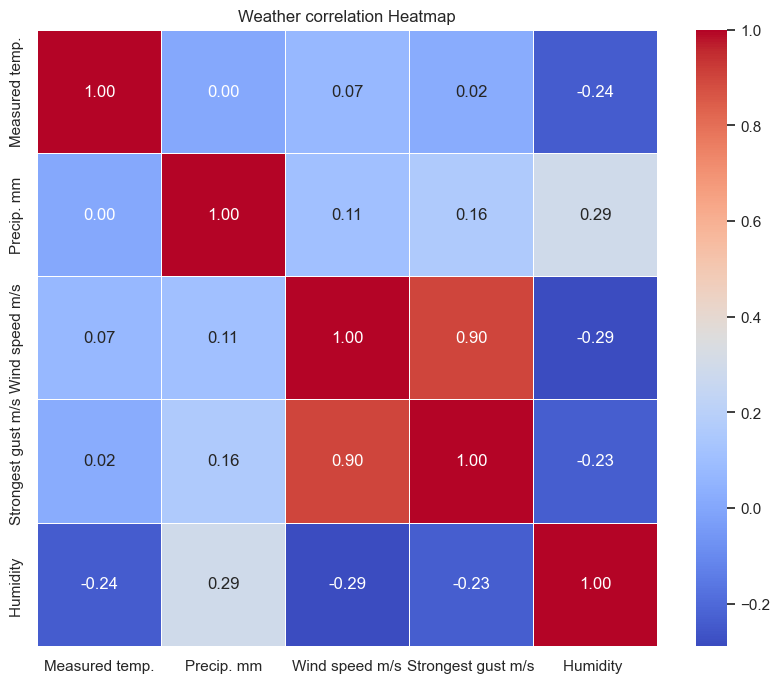

In [ ]:
# Calculate the correlation matrix
corr_matrix = final_df.iloc[:, 5:10].corr()

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)

# Adding titles and labels for clarity
plt.title('Weather correlation Heatmap')
plt.savefig('Weather Correlation Heatmap')
plt.show()

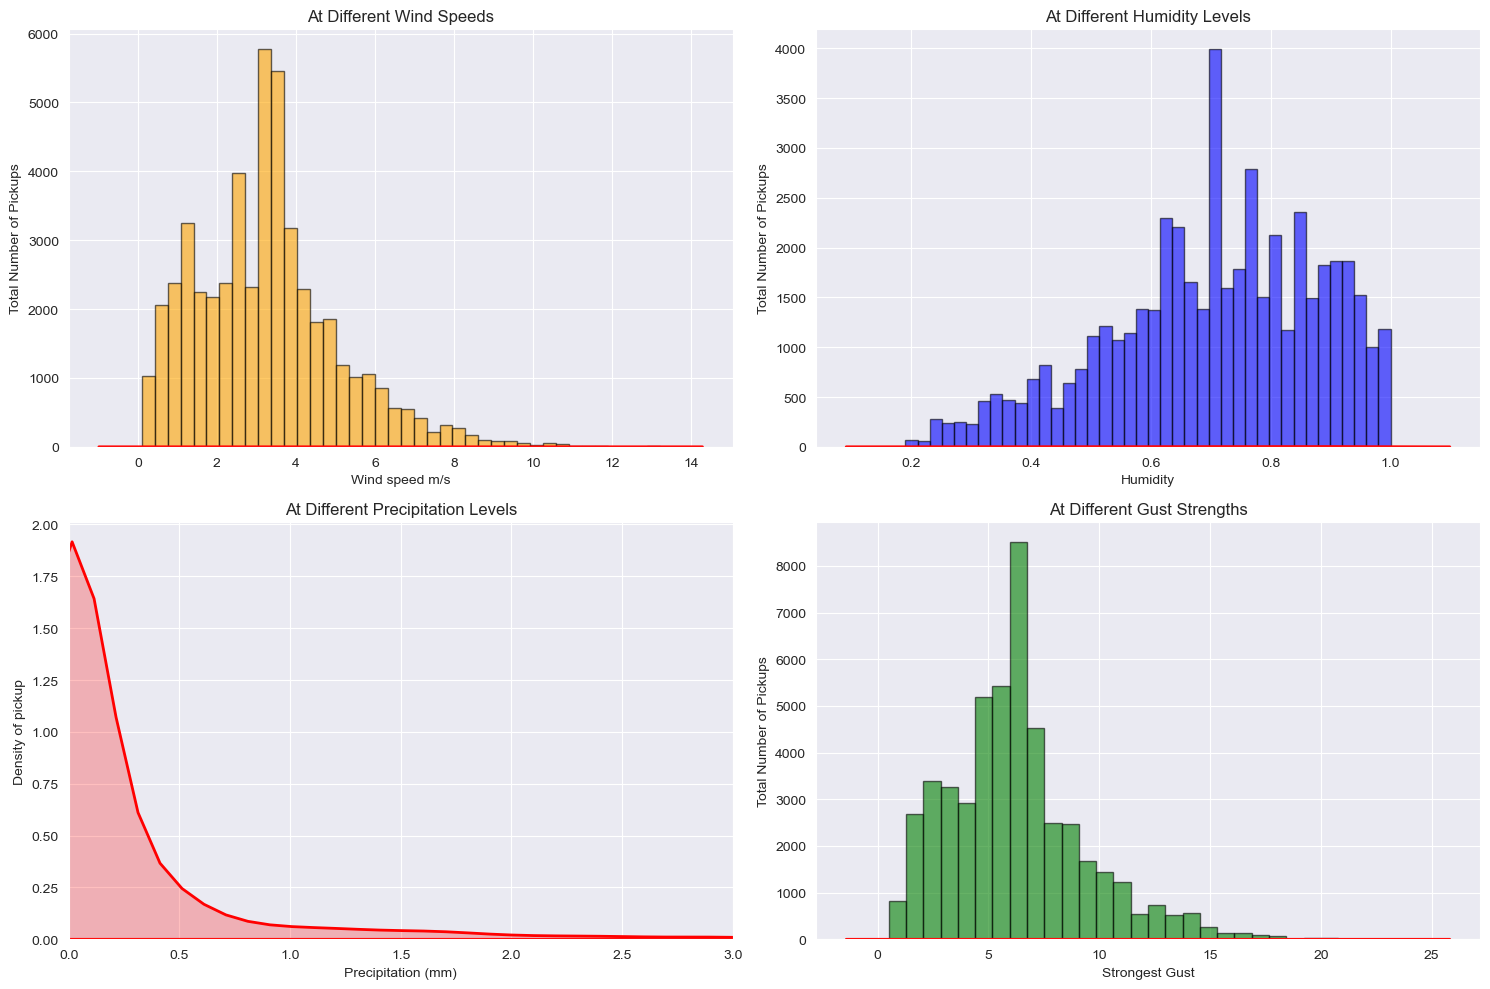

In [ ]:
temp_pickup_sum_wind = final_df.set_index('Wind speed m/s').iloc[:, 11:].sum(axis=1)
temp_pickup_sum_humidity = final_df.set_index('Humidity ').iloc[:, 11:].sum(axis=1)
temp_pickup_sum_gust = final_df.set_index('Strongest gust m/s').iloc[:, 11:].sum(axis=1)
temp_pickup_sum_precip = final_df.set_index('Precip. mm').iloc[:, 11:].sum(axis=1)

# Create a combined plot
plt.figure(figsize=(15, 10))

# Wind speed
plt.subplot(2, 2, 1)  # 2 rows, 2 columns, 1st subplot
plt.hist(temp_pickup_sum_wind.index, weights=temp_pickup_sum_wind.values, bins=40, edgecolor='black', color='orange', alpha=0.6)
sns.kdeplot(temp_pickup_sum_wind.index,  color='red', lw=2)
plt.xlabel('Wind speed m/s')
plt.ylabel('Total Number of Pickups')
plt.title('At Different Wind Speeds')

# Humidity
plt.subplot(2, 2, 2)  # 2 rows, 2 columns, 2nd subplot
plt.hist(temp_pickup_sum_humidity.index, weights=temp_pickup_sum_humidity.values, bins=40, edgecolor='black', color='blue', alpha=0.6)
sns.kdeplot(temp_pickup_sum_humidity.index, color='red', lw=2)
plt.xlabel('Humidity')
plt.ylabel('Total Number of Pickups')
plt.title('At Different Humidity Levels')

# Precipitation
plt.subplot(2, 2, 3)  # 2 rows, 2 columns, 4th subplot
#plt.hist(temp_pickup_sum_precip.index, weights=temp_pickup_sum_precip.values, bins=40, edgecolor='black', color='red', alpha=0.6)
sns.kdeplot(temp_pickup_sum_precip.index,  color='red', lw=2,fill=True)
plt.xlim(0,3)
plt.xlabel('Precipitation (mm)')
plt.ylabel('Density of pickup')
plt.title('At Different Precipitation Levels')

# Strongest gust
plt.subplot(2, 2, 4)  # 2 rows, 2 columns, 3rd subplot
plt.hist(temp_pickup_sum_gust.index,weights=temp_pickup_sum_gust.values, bins=30, edgecolor='black', color='green', alpha=0.6)
sns.kdeplot(temp_pickup_sum_gust.index, color='red', lw=2)
plt.xlabel('Strongest Gust')
plt.ylabel('Total Number of Pickups')
plt.title('At Different Gust Strengths')

# Show the plot
plt.tight_layout()
plt.savefig('Weather versus Total bike pickup')
plt.show()





In [ ]:
final_df[final_df['started_hour'] == 0].sum(axis=1).mean()
final_df[final_df['started_hour'] == 1].sum(axis=1).mean()

58.13333333333333

In [ ]:
final_r_df.month]

AttributeError: 'DataFrame' object has no attribute 'months'

#  <span style="color: black; font-family: Oswald ;">*XG boost*</span>

##  <span style="color: red; font-family: Oswald ;">*Pickup*</span>

##### Without grid search

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,mean_squared_log_error,r2_score
import pandas as pd


X = final_df.iloc[:, :11]   # First 11 columns are features

# XGBoost parameters
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'learning_rate': 0.03,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.8,
    'alpha': 2,
    'lambda': 1,
    'min_child_weight':12,
    'gamma':1.4
}
'''
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'learning_rate': 0.03,
    'max_depth': 2,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'alpha': 2,
    'lambda': 0.9,
    'min_child_weight':6,
    'gamma':2
}'''

# Initialize dictionaries to store RMSE results, trained models, and evaluation results
rmse_results = {}
models = {}
evals_results = {}
r2_results={}
rmsle_results = {}
# Loop through all target columns
target_columns = final_df.columns[11:]
for target_col in target_columns:
    station_y = final_df[target_col]

    # Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split(X, station_y, test_size=0.15, shuffle=False)

    # Convert to DMatrix format
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    # Initialize a dictionary to store evaluation results for the current target column
    evals_result = {}

    # Train the model and store the evaluation results
    bst = xgb.train(params, dtrain, num_boost_round=700, evals=[(dtrain, 'train'), (dtest, 'eval')], verbose_eval=False, evals_result=evals_result)

    # Store the trained model
    models[target_col] = bst

    # Store the evaluation results for the current target column
    evals_results[target_col] = evals_result

    # Predict on test set
    y_pred = bst.predict(dtest)

    # Calculate RMSE & R-Squared
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2= r2_score(y_test, y_pred)
    y_pred_t = np.maximum(0, y_pred)
    rmsle = np.sqrt(mean_squared_log_error(y_test, y_pred_t))
    # Store RMSE & R-squared
    rmse_results[target_col] = rmse
    r2_results[target_col]=r2
    rmsle_results[target_col] = rmsle
# Print RMSE results
average_rmse = np.mean(list(rmse_results.values()))
average_r2 = np.mean(list(r2_results.values()))
average_rmsle = np.mean(list(rmsle_results.values()))

for target, rmse in rmse_results.items():
    print(f"RMSE for station {target}: {rmse}")
for target, r2 in r2_results.items():
    print(f"R-Squared for station {target}: {r2}")
for target, rmsle in rmsle_results.items():
    print(f"RMLE for station {target}: {rmsle}")

print(f'Average RMSE of Xgboost for cluster 2 is {average_rmse}')
print(f'Average R-squared of Xgboost for cluster 2 is {average_r2}')
print(f'Average RMLSE of XGBoost for cluster 2 is {average_rmsle}')

RMSE for station 641: 1.3394058771866033
RMSE for station 2322: 1.2580415258912676
RMSE for station 214: 1.282293668087653
RMSE for station 157: 1.6595935707039007
RMSE for station 301: 1.1476739498096253
RMSE for station 87: 1.1565788891587097
RMSE for station 75: 1.0434692288694205
RMSE for station 2313: 1.1831301636583287
RMSE for station 5: 1.0010798351682322
RMSE for station 794: 1.6334407455678628
RMSE for station 138: 1.5775084430366295
R-Squared for station 641: 0.30005490727726625
R-Squared for station 2322: 0.4086760405090878
R-Squared for station 214: 0.5223476686233215
R-Squared for station 157: 0.3806041260264529
R-Squared for station 301: 0.3511378385413292
R-Squared for station 87: 0.3173533221742626
R-Squared for station 75: 0.3756626140678836
R-Squared for station 2313: 0.4300614934618595
R-Squared for station 5: 0.38490143240599795
R-Squared for station 794: 0.5030047418123577
R-Squared for station 138: 0.5246170294044323
RMLE for station 641: 0.537715921178356
RMLE f

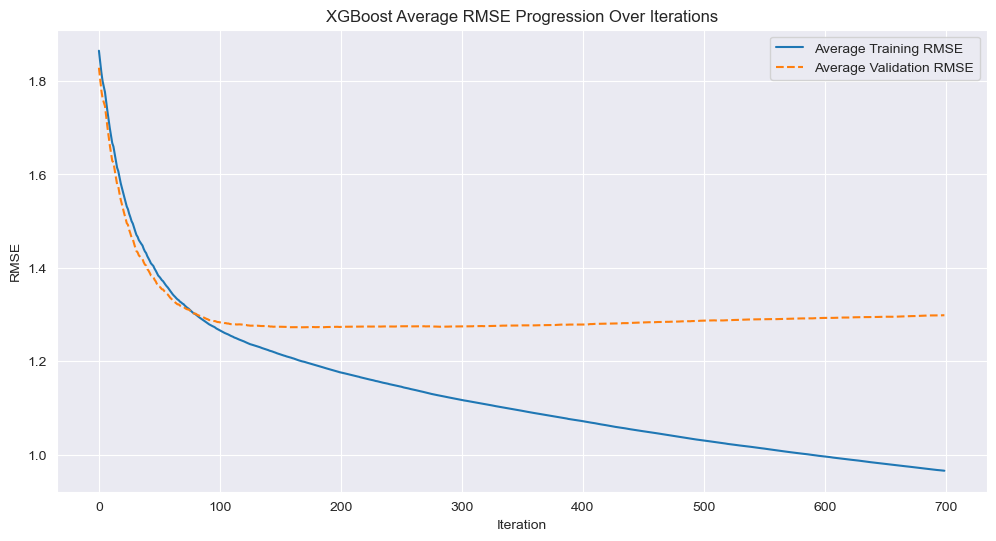

In [ ]:

# Collect training and validation RMSEs over iterations for each station
all_train_rmse = [evals_results[station]['train']['rmse'] for station in evals_results]
all_eval_rmse = [evals_results[station]['eval']['rmse'] for station in evals_results]

# Average RMSE values across stations at each iteration
avg_train_rmse = np.mean(all_train_rmse, axis=0)
avg_eval_rmse = np.mean(all_eval_rmse, axis=0)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(avg_train_rmse, label='Average Training RMSE', linestyle='-')
plt.plot(avg_eval_rmse, label='Average Validation RMSE', linestyle='--')

plt.title('XGBoost Average RMSE Progression Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.legend()
plt.savefig('XGBoost Bike Pickup validation')
plt.show()

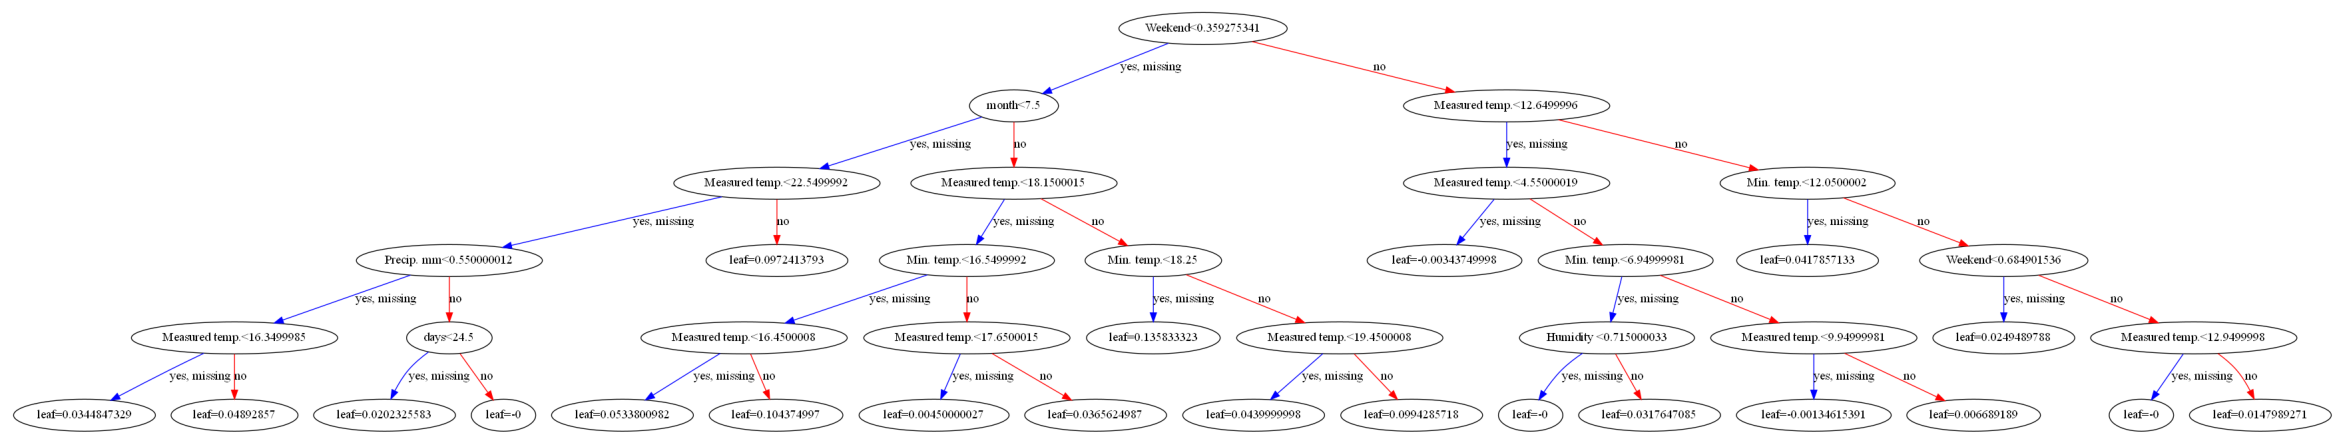

In [ ]:
import matplotlib.image as mpimg
from xgboost import to_graphviz
import graphviz

# Convert the model to dot format for visualization
dot_data = xgb.to_graphviz(bst, num_trees=0)

# Render the dot data to a file (e.g. png format)
dot_data.format = 'png'
dot_data.render(filename='tree')

# Display the tree using matplotlib
img = mpimg.imread('tree.png')
plt.figure(figsize=(30, 100))
plt.imshow(img)
plt.axis('off')  # Turn off axis numbers and ticks

# Save the figure in higher resolution
plt.savefig('large_tree.png', dpi=300)

plt.show()

##  <span style="color: red; font-family: Oswald ;">*Return*</span>

In [ ]:

X_r = final_r_df.iloc[:, :11]   # First 11 columns are features

# XGBoost parameters
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'learning_rate': 0.02,
    'max_depth': 4,
    'subsample': 0.5,
    'colsample_bytree': 0.8,
    'alpha': 3,
    'lambda': 1,
    'min_child_weight':8,
    'gamma':1.4
}

# Initialize dictionaries to store RMSE results, trained models, and evaluation results
rmse_results_r = {}
models_r = {}
evals_results_r = {}
r2_results_r={}
rmsle_results_r = {}
# Loop through all target columns
target_r_columns = final_r_df.columns[11:]
for target_col in target_r_columns:
    station_y = final_r_df[target_col]

    # Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split(X_r, station_y, test_size=0.15, shuffle=False)

    # Convert to DMatrix format
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    # Initialize a dictionary to store evaluation results for the current target column
    evals_result_r = {}

    # Train the model and store the evaluation results
    bst = xgb.train(params, dtrain, num_boost_round=300, evals=[(dtrain, 'train'), (dtest, 'eval')], verbose_eval=False, evals_result=evals_result)

    # Store the trained model
    models_r[target_col] = bst

    # Store the evaluation results for the current target column
    evals_results_r[target_col] = evals_result

    # Predict on test set
    y_r_pred = bst.predict(dtest)

    # Calculate RMSE, R-Squared & RMLSE
    rmse = mean_squared_error(y_test, y_r_pred, squared=False)
    r2= r2_score(y_test, y_r_pred)
    y_test_abs = np.abs(y_test)
    y_pred_abs = np.abs(y_r_pred)
    rmsle = np.sqrt(mean_squared_log_error(y_test_abs, y_pred_abs))
    # Store RMSE, R-squared & RMLSE
    rmse_results_r[target_col] = rmse
    r2_results_r[target_col]=r2
    rmsle_results_r[target_col] = rmsle
# Print results
average_rmse = np.mean(list(rmse_results_r.values()))
average_r2 = np.mean(list(r2_results_r.values()))
average_rmsle = np.mean(list(rmsle_results_r.values()))
for target, rmse in rmse_results.items():
    print(f"RMSE for station {target}: {rmse}")
for target, r2 in r2_results.items():
    print(f"R-squared for station {target}: {r2}")
for target, rmsle in rmsle_results.items():
    print(f"RMLSE for station {target}: {rmsle}")

print(f'Average RMSE of Xgboost for cluster 2 is {average_rmse}')
print(f'Average R-squared of Xgboost for cluster 2 is {average_r2}')
print(f'Average RMLSE of XGBoost for cluster 2 is {average_rmsle}')

RMSE for station 641: 1.3394058771866033
RMSE for station 2322: 1.2580415258912676
RMSE for station 214: 1.282293668087653
RMSE for station 157: 1.6595935707039007
RMSE for station 301: 1.1476739498096253
RMSE for station 87: 1.1565788891587097
RMSE for station 75: 1.0434692288694205
RMSE for station 2313: 1.1831301636583287
RMSE for station 5: 1.0010798351682322
RMSE for station 794: 1.6334407455678628
RMSE for station 138: 1.5775084430366295
R-squared for station 641: 0.30005490727726625
R-squared for station 2322: 0.4086760405090878
R-squared for station 214: 0.5223476686233215
R-squared for station 157: 0.3806041260264529
R-squared for station 301: 0.3511378385413292
R-squared for station 87: 0.3173533221742626
R-squared for station 75: 0.3756626140678836
R-squared for station 2313: 0.4300614934618595
R-squared for station 5: 0.38490143240599795
R-squared for station 794: 0.5030047418123577
R-squared for station 138: 0.5246170294044323
RMLSE for station 641: 0.537715921178356
RMLSE

In [ ]:
len(final_r_df)

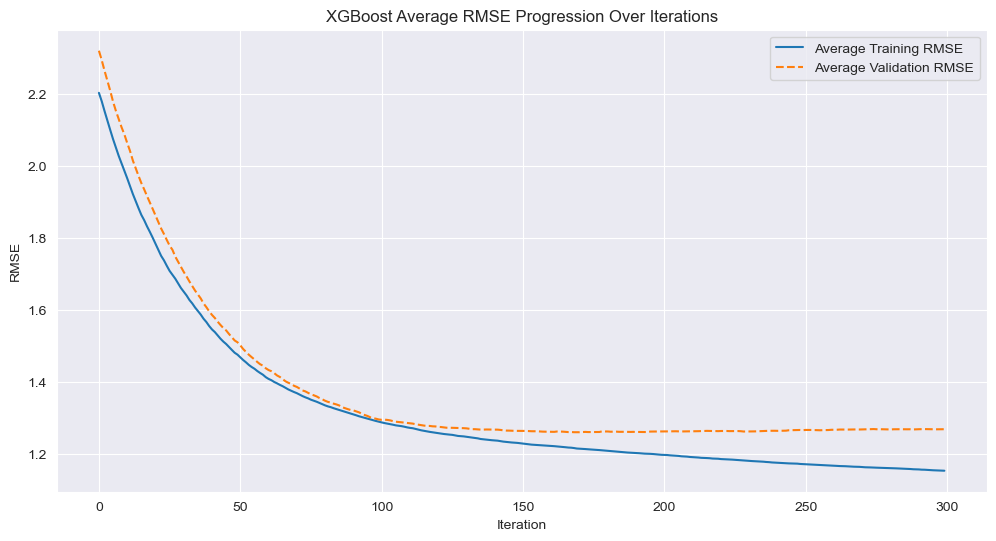

In [ ]:

# Collect training and validation RMSEs over iterations for each station
all_train_rmse = [evals_results_r[station]['train']['rmse'] for station in evals_results_r]
all_eval_rmse = [evals_results_r[station]['eval']['rmse'] for station in evals_results_r]

# Average RMSE values across stations at each iteration
avg_train_rmse = np.mean(all_train_rmse, axis=0)
avg_eval_rmse = np.mean(all_eval_rmse, axis=0)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(avg_train_rmse, label='Average Training RMSE', linestyle='-')
plt.plot(avg_eval_rmse, label='Average Validation RMSE', linestyle='--')

plt.title('XGBoost Average RMSE Progression Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.legend()
plt.savefig('XGBoost Bike return validation')
plt.show()

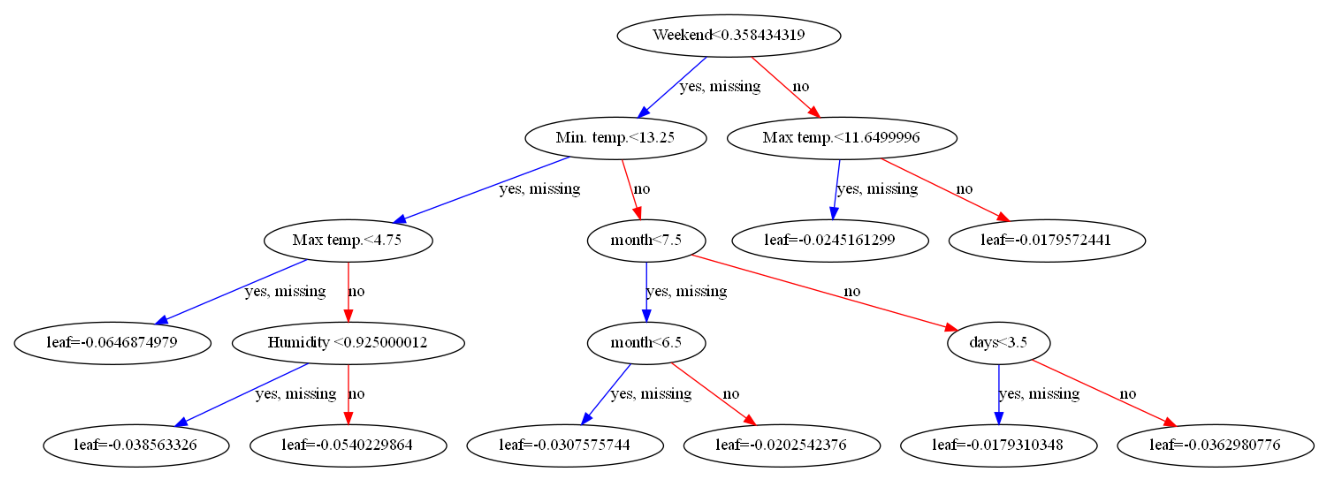

In [ ]:
# Convert the model to dot format for visualization
dot_data = xgb.to_graphviz(bst, num_trees=0)

# Render the dot data to a file (e.g. png format)
dot_data.format = 'png'
dot_data.render(filename='tree')

# Display the tree using matplotlib
img = mpimg.imread('tree.png')
plt.figure(figsize=(18, 6))
plt.imshow(img)
plt.axis('off')  # Turn off axis numbers and ticks

# Save the figure in higher resolution
plt.savefig('Tree expansion of Bike return.png', dpi=1000)

plt.show()

In [ ]:
final_r_df['month'].dtype

dtype('int32')

In [ ]:
# Prediction function based on the input
def predict_for_input(input_data, target_columns, models):
    input_dmatrix = xgb.DMatrix(input_data)
    predictions = {}
    for col in target_columns:
        model = models[col]
        predictions[col] = round(model.predict(input_dmatrix)[0])
    return predictions

# Prepare the input data
input_values = [24,13, 10, 7.8,9.5,9.2,0,1.5,2.2,0.87,0]
#input_values=[24,14,10,10.0,12.6,12.6,0.1,8.2,12.6,0.62,0]
input_df = pd.DataFrame([input_values], columns=X.columns)
input_r_df = pd.DataFrame([input_values], columns=X_r.columns)

# Predict using the trained models
xg_dict = predict_for_input(input_df, target_columns, models)
xg_r_dict = predict_for_input(input_r_df, target_r_columns, models_r)

print(xg_dict)
print(xg_r_dict)

{641: 5, 2322: 5, 214: 5, 157: 5, 301: 4, 87: 3, 75: 4, 2313: 6, 5: 2, 794: 7, 138: 6}
{641: -2, 2322: -2, 2313: -2, 75: -1, 157: -2, 301: -2, 214: -1, 138: -3, 5: -1, 794: -3, 87: -2}


In [ ]:
{2322: 5, 641: 5, 138: 6, 794: 7, 214: 5, 75: 4, 157: 5, 87: 3, 2313: 6, 5: 2, 301: 4}
{157: -2, 138: -3, 214: -1, 87: -2, 2322: -2, 301: -2, 2313: -2, 794: -3, 5: -1, 641: -2, 75: -1}

Index([157, 138, 214, 87, 2322, 301, 2313, 794, 5, 641, 75], dtype='object')

In [ ]:
october_test=pd.read_csv(r'C:\all others\Study\Study\Master Thesis papers\Dataset\10 (1).csv')
october_test_1=conversion(october_test)
october_r_test_1=returns_conversion(october_test)

In [ ]:
october_test_1[(october_test_1["started_date"]=="2023-10-24")& (october_test_1["started_hour"]==13)][[5, 75, 87, 138, 157, 214, 301, 641, 794, 2313, 2322]]

,5,75,87,138,157,214,301,641,794,2313,2322
17112,9,7,2,3,4,7,6,5,12,4,5


In [ ]:
october_r_test_1[(october_r_test_1["ended_date"]=="2023-10-24")& (october_r_test_1["ended_hour"]==13)][[5, 75, 87, 138, 157, 214, 301, 641, 794, 2313, 2322]]

,5,75,87,138,157,214,301,641,794,2313,2322
16786,-2,-3,-6,-3,-5,-1,-4,-2,-6,0,-1


# Metaheuristic

##  <span style="color: red; font-family: Oswald ;">*Pickup*</span>

In [ ]:
from pyswarm import pso


X = final_df.iloc[:, :11]   # First 11 columns are features

# Initialize dictionaries to store RMSE results, trained models, and evaluation results
rmse_results = {}
models_m = {}
evals_results = {}
r2_results={}
rmlse_results={}
# Define the objective function for PSO
def objective(params, dtrain, dtest):
    learning_rate, max_depth, subsample, colsample_bytree, min_child_weight, alpha, lambda_,gamma = params

    xgb_params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'learning_rate': learning_rate,
        'max_depth': int(max_depth),
        'subsample': subsample,
        'colsample_bytree': colsample_bytree,
        'alpha': alpha,
        'lambda': lambda_,
        'min_child_weight': int(min_child_weight),
        'gamma': gamma
    }

    bst = xgb.train(xgb_params, dtrain, num_boost_round=300, evals=[(dtrain, 'train')], verbose_eval=False)
    y_pred = bst.predict(dtest)
    return mean_squared_error(y_test, y_pred, squared=False)

# Loop through all target columns
target_columns_m = final_df.columns[11:]
for target_col in target_columns_m:
    station_y = final_df[target_col]
    X_train, X_test, y_train, y_test = train_test_split(X, station_y, test_size=0.20, shuffle=False)

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    # Bounds for the hyperparameters
    lb = [0.01, 5, 0.6, 0.6, 1, 0.7, 7, 1]
    ub = [0.04, 10, 0.9, 0.9, 4, 3, 16, 4]


    best_params, _ = pso(objective, lb, ub, args=(dtrain, dtest), swarmsize=10, maxiter=5)

    # Update the model parameters with the optimized values
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'learning_rate': best_params[0],
        'max_depth': int(best_params[1]),
        'subsample': best_params[2],
        'colsample_bytree': best_params[3],
        'alpha': best_params[4],
        'lambda': best_params[5],
        'min_child_weight': int(best_params[6]),
        'gamma': best_params[7]
    }

    evals_result = {}
    bst = xgb.train(params, dtrain, num_boost_round=400, evals=[(dtrain, 'train'), (dtest, 'eval')], verbose_eval=False, evals_result=evals_result)

    models_m[target_col] = bst
    evals_results[target_col] = evals_result
    y_pred = bst.predict(dtest)

    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2= r2_score(y_test, y_pred)
    y_pred_t = np.maximum(0, y_pred)
    rmlse = np.sqrt(mean_squared_log_error(y_test, y_pred_t))
    # Store RMSE & R-squared
    rmse_results[target_col] = rmse
    r2_results[target_col]=r2
    rmlse_results[target_col] = rmlse
# Print RMSE results
average_rmse = np.mean(list(rmse_results.values()))
average_r2 = np.mean(list(r2_results.values()))
average_rmlse = np.mean(list(rmlse_results.values()))
for i, val in enumerate(best_params):
    print(f'Best parameter {i}: {val}')

for target, rmse in rmse_results.items():
    print(f"RMSE for station {target}: {rmse}")
for target, r2 in r2_results.items():
    print(f"R-squared for station {target}: {r2}")
for target, r2 in rmlse_results.items():
    print(f"RMLSE for station {target}: {rmlse}")

print(f'Average RMSE of Xgboost(PSO) for cluster 2 is {average_rmse}')
print(f'Average R-squared of Xgboost(PSO) for cluster 2 is {average_r2}')
print(f'Average RMLSE of Xgboost(PSO) for cluster 2 is {average_rmlse}')


Stopping search: maximum iterations reached --> 5
Stopping search: maximum iterations reached --> 5
Stopping search: maximum iterations reached --> 5
Stopping search: maximum iterations reached --> 5
Stopping search: maximum iterations reached --> 5
Stopping search: maximum iterations reached --> 5
Stopping search: maximum iterations reached --> 5
Stopping search: maximum iterations reached --> 5
Stopping search: maximum iterations reached --> 5
Stopping search: maximum iterations reached --> 5
Stopping search: maximum iterations reached --> 5
Best parameter 0: 0.033090851042494984
Best parameter 1: 5.3739360048468034
Best parameter 2: 0.7546884808527253
Best parameter 3: 0.8366386678433558
Best parameter 4: 3.530145306942273
Best parameter 5: 2.9273028573553517
Best parameter 6: 10.067876547693736
Best parameter 7: 2.6455954053429416
RMSE for station 641: 1.3199948781018616
RMSE for station 2322: 1.2758600425662607
RMSE for station 214: 1.3372302900937105
RMSE for station 157: 1.63291

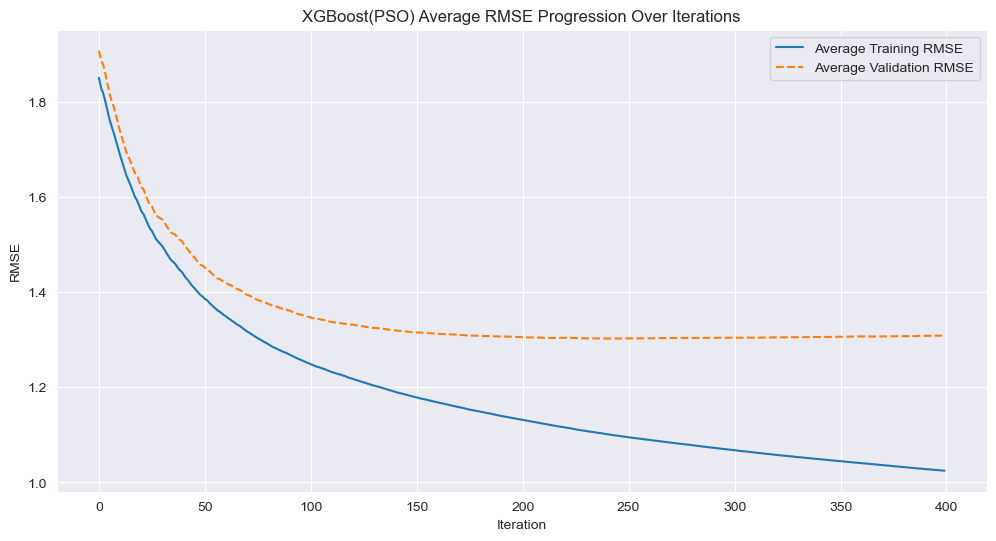

In [ ]:
# training and validation RMSEs over iterations for each station
all_train_rmse = [evals_results[station]['train']['rmse'] for station in evals_results]
all_eval_rmse = [evals_results[station]['eval']['rmse'] for station in evals_results]

# average RMSE values across stations at each iteration
avg_train_rmse = np.mean(all_train_rmse, axis=0)
avg_eval_rmse = np.mean(all_eval_rmse, axis=0)

# the average training and validation RMSE
plt.figure(figsize=(12, 6))
plt.plot(avg_train_rmse, label='Average Training RMSE', linestyle='-')
plt.plot(avg_eval_rmse, label='Average Validation RMSE', linestyle='--')
plt.title('XGBoost(PSO) Average RMSE Progression Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.legend()
plt.savefig('XGBoost(PSO) validation loss of Bike Pickup')
plt.show()

##  <span style="color: red; font-family: Oswald ;">*Return*</span>

In [ ]:
X = final_r_df.iloc[:, :11]   # First 11 columns are features

# Initialize dictionaries to store RMSE results, trained models, and evaluation results
rmse_results = {}
models_r_m = {}
evals_results_r = {}
r2_results={}
rmlse_results={}

# Loop through all target columns
target_columns_r_m = final_r_df.columns[11:]
for target_col in target_columns_r_m:
    station_y = final_r_df[target_col]
    X_train, X_test, y_train, y_test = train_test_split(X, station_y, test_size=0.20, shuffle=False)

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    # Bounds for the hyperparameters
    lb = [0.01, 5, 0.6, 0.6, 1, 0.7, 7, 1]
    ub = [0.04, 10, 0.9, 0.9, 4, 3, 16, 4]


    best_params, _ = pso(objective, lb, ub, args=(dtrain, dtest), swarmsize=10, maxiter=5)

    # Update the model parameters with the optimized values
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'learning_rate': best_params[0],
        'max_depth': int(best_params[1]),
        'subsample': best_params[2],
        'colsample_bytree': best_params[3],
        'alpha': best_params[4],
        'lambda': best_params[5],
        'min_child_weight': int(best_params[6]),
        'gamma': best_params[7]
    }

    evals_result_r = {}
    bst = xgb.train(params, dtrain, num_boost_round=400, evals=[(dtrain, 'train'), (dtest, 'eval')], verbose_eval=False, evals_result=evals_result)

    models_r_m[target_col] = bst
    evals_results_r[target_col] = evals_result
    y_pred = bst.predict(dtest)

    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2= r2_score(y_test, y_pred)
    y_test_abs = np.abs(y_test)
    y_pred_abs = np.abs(y_pred)
    rmsle = np.sqrt(mean_squared_log_error(y_test_abs, y_pred_abs))
    # Store RMSE & R-squared
    rmse_results[target_col] = rmse
    r2_results[target_col]=r2
    rmlse_results[target_col] = rmlse
# Print RMSE results
average_rmse = np.mean(list(rmse_results.values()))
average_r2 = np.mean(list(r2_results.values()))
average_rmlse = np.mean(list(rmlse_results.values()))
for i, val in enumerate(best_params):
    print(f'Best parameter {i}: {val}')

for target, rmse in rmse_results.items():
    print(f"RMSE for station {target}: {rmse}")
for target, r2 in r2_results.items():
    print(f"R-squared for station {target}: {r2}")
for target, r2 in rmlse_results.items():
    print(f"RMLSE for station {target}: {rmlse}")

print(f'Average RMSE of Xgboost(PSO) for cluster 2 is {average_rmse}')
print(f'Average R-squared of Xgboost(PSO) for cluster 2 is {average_r2}')
print(f'Average RMLSE of Xgboost(PSO) for cluster 2 is {average_rmlse}')

Stopping search: maximum iterations reached --> 5
Stopping search: maximum iterations reached --> 5
Stopping search: maximum iterations reached --> 5
Stopping search: maximum iterations reached --> 5
Stopping search: maximum iterations reached --> 5
Stopping search: maximum iterations reached --> 5
Stopping search: maximum iterations reached --> 5
Stopping search: maximum iterations reached --> 5
Stopping search: maximum iterations reached --> 5
Stopping search: maximum iterations reached --> 5
Stopping search: maximum iterations reached --> 5
Best parameter 0: 0.032474642261456854
Best parameter 1: 5.0
Best parameter 2: 0.6189732354792861
Best parameter 3: 0.9
Best parameter 4: 2.6773478679827605
Best parameter 5: 1.7099807086024832
Best parameter 6: 11.985693556600046
Best parameter 7: 1.0
RMSE for station 641: 1.3099162523806975
RMSE for station 2322: 1.5810504264708105
RMSE for station 2313: 1.1255189073923297
RMSE for station 75: 1.0109070192476326
RMSE for station 157: 1.55404450

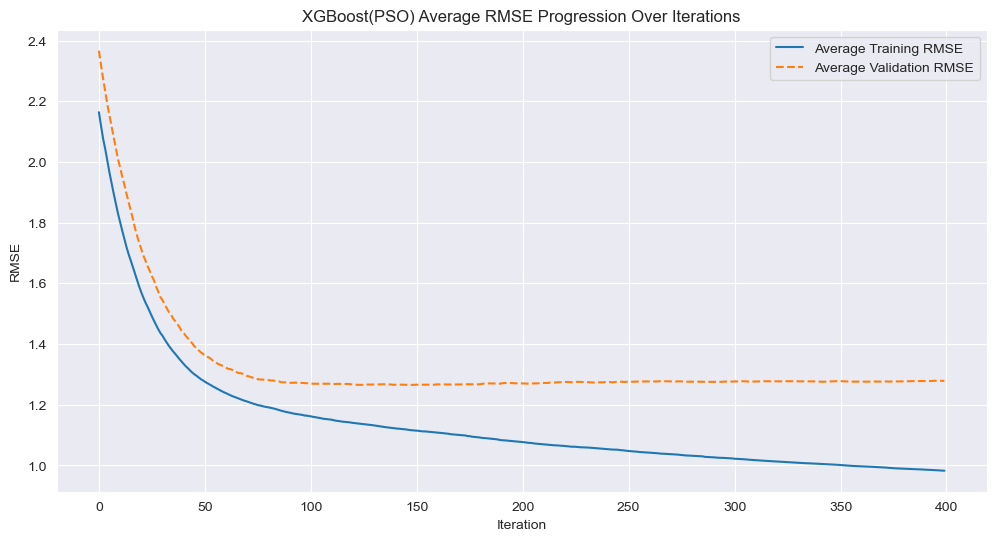

In [ ]:
all_train_rmse_r = [evals_results_r[target_col]['train']['rmse'] for target_col in evals_results_r]
all_eval_rmse_r = [evals_results_r[target_col]['eval']['rmse'] for target_col in evals_results_r]

# Calculate average RMSE values across target columns at each iteration
avg_train_rmse_r = np.mean(all_train_rmse_r, axis=0)
avg_eval_rmse_r = np.mean(all_eval_rmse_r, axis=0)

# Plot the average training and validation RMSE
plt.figure(figsize=(12, 6))
plt.plot(avg_train_rmse_r, label='Average Training RMSE', linestyle='-')
plt.plot(avg_eval_rmse_r, label='Average Validation RMSE', linestyle='--')
plt.title('XGBoost(PSO) Average RMSE Progression Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.legend()
plt.savefig('XGBoost(PSO) loss of bike return data')
plt.show()

In [ ]:

# Predict using the trained models
m_xg_dict = predict_for_input(input_df, target_columns_m, models_m)
m_r_xg_dict = predict_for_input(input_r_df, target_columns_r_m, models_r_m)
print(m_xg_dict)
print(m_r_xg_dict)

{641: 6, 2322: 4, 214: 5, 157: 5, 301: 4, 87: 3, 75: 4, 2313: 5, 5: 2, 794: 7, 138: 6}
{641: -2, 2322: -3, 2313: -2, 75: -1, 157: -3, 301: -2, 214: -1, 138: -3, 5: -1, 794: -4, 87: -2}


In [ ]:
xg_r_dict

{}

In [ ]:
{2322: 5, 641: 5, 138: 6, 794: 7, 214: 5, 75: 4, 157: 5, 87: 3, 2313: 6, 5: 2, 301: 4}
{157: -2, 138: -3, 214: -1, 87: -2, 2322: -2, 301: -2, 2313: -2, 794: -3, 5: -1, 641: -2, 75: -1}


In [ ]:
october_test=pd.read_csv(r'C:\all others\Study\Study\Master Thesis papers\Dataset\10 (1).csv')
october_test_1=conversion(october_test)
october_r_test_1=returns_conversion(october_test)

In [ ]:
october_test_1[(october_test_1["started_date"]=="2023-10-24")& (october_test_1["started_hour"]==13)][[5, 75, 87, 138, 157, 214, 301, 641, 794, 2313, 2322]]

,5,75,87,138,157,214,301,641,794,2313,2322
17112,9,7,2,3,4,7,6,5,12,4,5


In [ ]:
travel_data=pd.read_csv(r'C:\all others\Study\Study\Master Thesis papers\Dataset\Travel time per 10 km.csv')
travel_data['Date']=pd.to_datetime(travel_data['Date'])
travel_data.head(2)

,Date,Hour,Live speed km,Difference seconds,weekend
0,2023-10-21,17,44.9,23.0,1.0
1,2023-10-21,18,46.1,-8.0,1.0


In [ ]:
merged_df_1.head(3)

,started_date,started_hour,month,Min. temp.,Max temp.,Measured temp.,Precip. mm,Wind speed m/s,Strongest gust m/s,Humidity,...,1892,1893,1894,1895,1896,1897,1898,1900,367,368
0,2023-04-01,3,4,0.6,1.2,0.7,0.0,0.8,3.4,0.65,...,0,0,0,0,0,0,0,0,0,0
1,2023-04-01,4,4,-0.6,0.8,-0.6,0.0,1.2,1.8,0.70,...,0,0,0,0,1,0,0,0,0,0
2,2023-04-01,5,4,-0.8,-0.2,-0.4,0.0,1.4,2.4,0.71,...,0,0,0,0,0,0,0,0,0,1


# LSTM model

##  <span style="color: red; font-family: Oswald ;">*Pickup*</span>

In [ ]:
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from keras.layers import Dropout

y=final_df.iloc[:,11:]
X = final_df.iloc[:, :11]

# Splitting the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)
# Normalizing the features
X_scaler = StandardScaler()
X_train_normalized = X_scaler.fit_transform(X_train)
X_test_normalized = X_scaler.transform(X_test)

# Normalizing the target columns
y_scaler = StandardScaler()
y_train_normalized = y_scaler.fit_transform(y_train)
y_test_normalized = y_scaler.transform(y_test)

# Reshape input to be [samples, timesteps, features]
X_train_reshaped = X_train_normalized.reshape(X_train_normalized.shape[0], 1, X_train_normalized.shape[1])
X_test_reshaped = X_test_normalized.reshape(X_test_normalized.shape[0], 1, X_test_normalized.shape[1])

# LSTM model
model = Sequential()

# First LSTM layer with dropout
model.add(LSTM(15, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]), return_sequences=True))
model.add(Dropout(0.1))

# Optional: Second LSTM layer
model.add(LSTM(30, return_sequences=True))
model.add(Dropout(0.1))#-------

# Optional: Third LSTM layer
model.add(LSTM(20))#-------
#model.add(Dropout(0.2))

# Additional dense layer
model.add(Dense(30, activation='tanh'))

# Output layer
model.add(Dense(y_train_normalized.shape[1]))
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
model.fit(X_train_reshaped, y_train_normalized, validation_data=(X_test_reshaped, y_test_normalized), epochs=150, batch_size=25, verbose=2, shuffle=False)


Epoch 1/150
136/136 - 13s - loss: 0.9736 - val_loss: 0.8780 - 13s/epoch - 94ms/step
Epoch 2/150
136/136 - 1s - loss: 0.9011 - val_loss: 0.8299 - 1s/epoch - 8ms/step
Epoch 3/150
136/136 - 1s - loss: 0.8496 - val_loss: 0.7756 - 896ms/epoch - 7ms/step
Epoch 4/150
136/136 - 1s - loss: 0.8127 - val_loss: 0.7544 - 942ms/epoch - 7ms/step
Epoch 5/150
136/136 - 1s - loss: 0.7952 - val_loss: 0.7430 - 1s/epoch - 8ms/step
Epoch 6/150
136/136 - 1s - loss: 0.7929 - val_loss: 0.7357 - 993ms/epoch - 7ms/step
Epoch 7/150
136/136 - 1s - loss: 0.7826 - val_loss: 0.7305 - 993ms/epoch - 7ms/step
Epoch 8/150
136/136 - 1s - loss: 0.7726 - val_loss: 0.7279 - 929ms/epoch - 7ms/step
Epoch 9/150
136/136 - 1s - loss: 0.7710 - val_loss: 0.7218 - 970ms/epoch - 7ms/step
Epoch 10/150
136/136 - 1s - loss: 0.7616 - val_loss: 0.7180 - 935ms/epoch - 7ms/step
Epoch 11/150
136/136 - 1s - loss: 0.7522 - val_loss: 0.7151 - 935ms/epoch - 7ms/step
Epoch 12/150
136/136 - 1s - loss: 0.7497 - val_loss: 0.7087 - 914ms/epoch - 7ms/

Epoch 99/150
136/136 - 1s - loss: 0.6117 - val_loss: 0.6004 - 898ms/epoch - 7ms/step
Epoch 100/150
136/136 - 1s - loss: 0.6010 - val_loss: 0.5996 - 912ms/epoch - 7ms/step
Epoch 101/150
136/136 - 1s - loss: 0.6033 - val_loss: 0.6015 - 885ms/epoch - 7ms/step
Epoch 102/150
136/136 - 1s - loss: 0.6086 - val_loss: 0.5971 - 911ms/epoch - 7ms/step
Epoch 103/150
136/136 - 1s - loss: 0.6034 - val_loss: 0.5967 - 927ms/epoch - 7ms/step
Epoch 104/150
136/136 - 1s - loss: 0.6004 - val_loss: 0.5963 - 920ms/epoch - 7ms/step
Epoch 105/150
136/136 - 1s - loss: 0.6026 - val_loss: 0.5988 - 910ms/epoch - 7ms/step
Epoch 106/150
136/136 - 1s - loss: 0.6018 - val_loss: 0.5958 - 955ms/epoch - 7ms/step
Epoch 107/150
136/136 - 1s - loss: 0.6031 - val_loss: 0.5942 - 895ms/epoch - 7ms/step
Epoch 108/150
136/136 - 1s - loss: 0.6050 - val_loss: 0.5977 - 896ms/epoch - 7ms/step
Epoch 109/150
136/136 - 1s - loss: 0.5993 - val_loss: 0.5928 - 925ms/epoch - 7ms/step
Epoch 110/150
136/136 - 1s - loss: 0.6004 - val_loss: 0

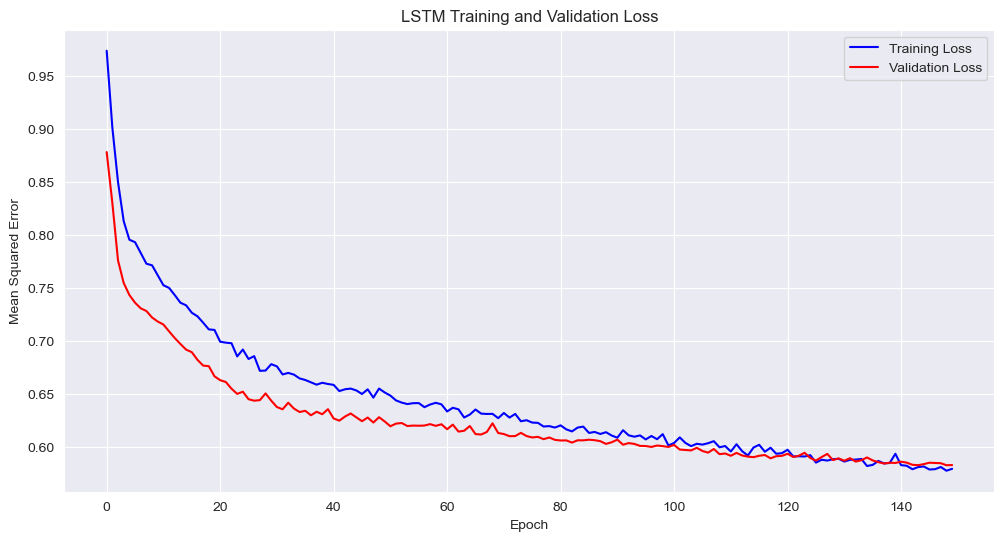

In [ ]:
# Assuming history is the result of your model training
history = model.history

# Plotting the training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.title('LSTM Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.savefig('LSTM Bike pickup validation')
plt.show()

In [ ]:

y_pred_normalized = model.predict(X_test_reshaped)

# Inverting the normalization to get the actual values
y_pred = y_scaler.inverse_transform(y_pred_normalized)
y_test_actual = y_scaler.inverse_transform(y_test_normalized)
rmse_scores = {}
r2_scores = {}
rmlse_scores={}
for i in range(y_test_actual.shape[1]):
    # RMSE calculation
    rmse = np.sqrt(mean_squared_error(y_test_actual[:, i], y_pred[:, i]))
    column_name = y_test.columns[i]  # Assuming y_test has column names
    rmse_scores[column_name] = rmse

    # R-squared calculation
    r2 = r2_score(y_test_actual[:, i], y_pred[:, i])
    r2_scores[column_name] = r2

    #RMLSE calculation
for i in range(y_test_actual.shape[1]):
    # Ensure the actual and predicted values are positive
    y_test_actual_positive = np.abs(y_test_actual[:, i])
    y_pred_positive = np.abs(y_pred[:, i])
     # Calculate RMSLE
    rmlse = np.sqrt(mean_squared_log_error(y_test_actual_positive, y_pred_positive))
    column_name = y_test.columns[i]  # Assuming y_test has column names
    rmlse_scores[column_name] = rmlse

# Calculating the average RMSE
average_rmse = np.mean(list(rmse_scores.values()))

# Calculating the average R-squared
average_r2 = np.mean(list(r2_scores.values()))
# Calculating the average RMSLE
average_rmlse = np.mean(list(rmlse_scores.values()))

# Printing the RMSE and R-squared scores
for column in rmse_scores:
    print(f"RMSE for {column}: {rmse_scores[column]}")
for column in r2_scores:
    print(f"R-squared for {column}: {r2_scores[column]}")
for column in rmlse_scores:
    print(f"RMSLE for {column}: {rmlse_scores[column]}")

print(f'Average RMSE of LSTM for cluster 2 is {average_rmse}')
print(f'Average R-squared of LSTM for cluster 2 is {average_r2}')
print(f'Average RMSLE of LSTM for cluster 2 is {average_rmlse}')

19/19 [==============================] - 2s 4ms/step
RMSE for 641: 1.407196036456111
RMSE for 2322: 1.3290988959145869
RMSE for 214: 1.2142698868342603
RMSE for 157: 1.5174688952844955
RMSE for 301: 1.2905562962775643
RMSE for 87: 1.030697630548261
RMSE for 75: 0.9702361929032387
RMSE for 2313: 1.314545824069584
RMSE for 5: 1.1248727508252154
RMSE for 794: 1.6970902169832358
RMSE for 138: 1.5067291772191207
R-squared for 641: 0.3306042232721489
R-squared for 2322: 0.39042188182156434
R-squared for 214: 0.4808109548466135
R-squared for 157: 0.4712988156452246
R-squared for 301: 0.34987297004891604
R-squared for 87: 0.30063424566717
R-squared for 75: 0.3271380972814225
R-squared for 2313: 0.45425227137071633
R-squared for 5: 0.2634339819717675
R-squared for 794: 0.51790039734844
R-squared for 138: 0.4666498035469854
RMSLE for 641: 0.5250186759184362
RMSLE for 2322: 0.4680643821583535
RMSLE for 214: 0.4531550582855257
RMSLE for 157: 0.521203514650718
RMSLE for 301: 0.5085779251858691
RMSL

In [ ]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_23 (LSTM)              (None, 1, 15)             1620      
                                                                 
 dropout_15 (Dropout)        (None, 1, 15)             0         
                                                                 
 lstm_24 (LSTM)              (None, 1, 30)             5520      
                                                                 
 dropout_16 (Dropout)        (None, 1, 30)             0         
                                                                 
 lstm_25 (LSTM)              (None, 20)                4080      
                                                                 
 dense_14 (Dense)            (None, 30)                630       
                                                                 
 dense_15 (Dense)            (None, 11)               

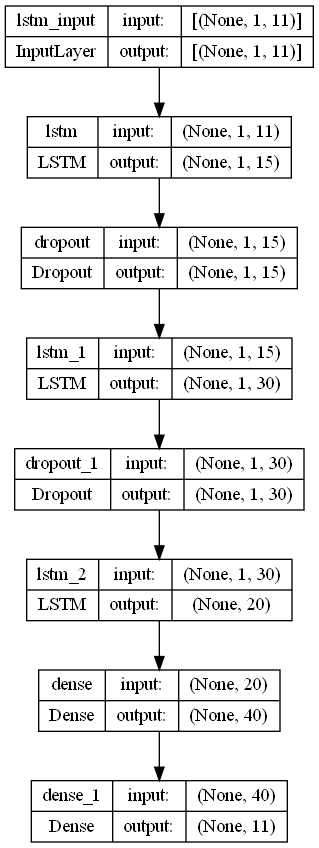

In [ ]:
from tensorflow.keras.utils import plot_model

# Assuming 'model' is your Keras model
plot_model(model, to_file='model_diagram.png', show_shapes=True, show_layer_names=True)



##  <span style="color: red; font-family: Oswald ;">*Return*</span>

In [ ]:
y_r=final_r_df.iloc[:,11:]
X_r = final_r_df.iloc[:, :11]

# Splitting the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_r, y_r, test_size=0.15, random_state=42)
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)
# Normalizing the features
X_scaler_r = StandardScaler()
X_train_normalized = X_scaler_r.fit_transform(X_train)
X_test_normalized = X_scaler_r.transform(X_test)

# Normalizing the target columns
y_scaler_r = StandardScaler()
y_train_normalized = y_scaler_r.fit_transform(y_train)
y_test_normalized = y_scaler_r.transform(y_test)

# Reshape input to be [samples, timesteps, features]
X_train_reshaped = X_train_normalized.reshape(X_train_normalized.shape[0], 1, X_train_normalized.shape[1])
X_test_reshaped = X_test_normalized.reshape(X_test_normalized.shape[0], 1, X_test_normalized.shape[1])

# LSTM model
model_r = Sequential()

# First LSTM layer with dropout
model_r.add(LSTM(5, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]), return_sequences=True))
model_r.add(Dropout(0.1))

# Optional: Second LSTM layer
model_r.add(LSTM(10, return_sequences=True))
#model.add(Dropout(0.1))

# Optional: Third LSTM layer
model_r.add(LSTM(30))
#model.add(Dropout(0.2))

# Additional dense layer
model_r.add(Dense(10, activation='tanh'))

# Output layer
model_r.add(Dense(y_train_normalized.shape[1]))
model_r.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
model_r.fit(X_train_reshaped, y_train_normalized, validation_data=(X_test_reshaped, y_test_normalized), epochs=150, batch_size=20, verbose=2, shuffle=False)


Epoch 1/150
177/177 - 18s - loss: 0.9873 - val_loss: 0.8149 - 18s/epoch - 103ms/step
Epoch 2/150
177/177 - 2s - loss: 0.9143 - val_loss: 0.7825 - 2s/epoch - 9ms/step
Epoch 3/150
177/177 - 2s - loss: 0.8837 - val_loss: 0.7709 - 2s/epoch - 10ms/step
Epoch 4/150
177/177 - 2s - loss: 0.8778 - val_loss: 0.7649 - 2s/epoch - 10ms/step
Epoch 5/150
177/177 - 1s - loss: 0.8737 - val_loss: 0.7614 - 1s/epoch - 8ms/step
Epoch 6/150
177/177 - 2s - loss: 0.8677 - val_loss: 0.7582 - 2s/epoch - 9ms/step
Epoch 7/150
177/177 - 2s - loss: 0.8661 - val_loss: 0.7552 - 2s/epoch - 10ms/step
Epoch 8/150
177/177 - 2s - loss: 0.8669 - val_loss: 0.7533 - 2s/epoch - 9ms/step
Epoch 9/150
177/177 - 2s - loss: 0.8657 - val_loss: 0.7510 - 2s/epoch - 9ms/step
Epoch 10/150
177/177 - 2s - loss: 0.8594 - val_loss: 0.7503 - 2s/epoch - 10ms/step
Epoch 11/150
177/177 - 2s - loss: 0.8596 - val_loss: 0.7494 - 2s/epoch - 9ms/step
Epoch 12/150
177/177 - 2s - loss: 0.8592 - val_loss: 0.7483 - 2s/epoch - 12ms/step
Epoch 13/150
177

Epoch 101/150
177/177 - 1s - loss: 0.6180 - val_loss: 0.5129 - 1s/epoch - 8ms/step
Epoch 102/150
177/177 - 2s - loss: 0.6116 - val_loss: 0.5116 - 2s/epoch - 10ms/step
Epoch 103/150
177/177 - 2s - loss: 0.6065 - val_loss: 0.5144 - 2s/epoch - 10ms/step
Epoch 104/150
177/177 - 2s - loss: 0.6082 - val_loss: 0.5159 - 2s/epoch - 9ms/step
Epoch 105/150
177/177 - 2s - loss: 0.6027 - val_loss: 0.5122 - 2s/epoch - 9ms/step
Epoch 106/150
177/177 - 2s - loss: 0.5992 - val_loss: 0.5086 - 2s/epoch - 9ms/step
Epoch 107/150
177/177 - 2s - loss: 0.5997 - val_loss: 0.5091 - 2s/epoch - 8ms/step
Epoch 108/150
177/177 - 2s - loss: 0.6119 - val_loss: 0.5073 - 2s/epoch - 10ms/step
Epoch 109/150
177/177 - 2s - loss: 0.5992 - val_loss: 0.5109 - 2s/epoch - 10ms/step
Epoch 110/150
177/177 - 2s - loss: 0.6011 - val_loss: 0.5094 - 2s/epoch - 8ms/step
Epoch 111/150
177/177 - 1s - loss: 0.6035 - val_loss: 0.5096 - 1s/epoch - 8ms/step
Epoch 112/150
177/177 - 2s - loss: 0.6066 - val_loss: 0.5075 - 2s/epoch - 10ms/step

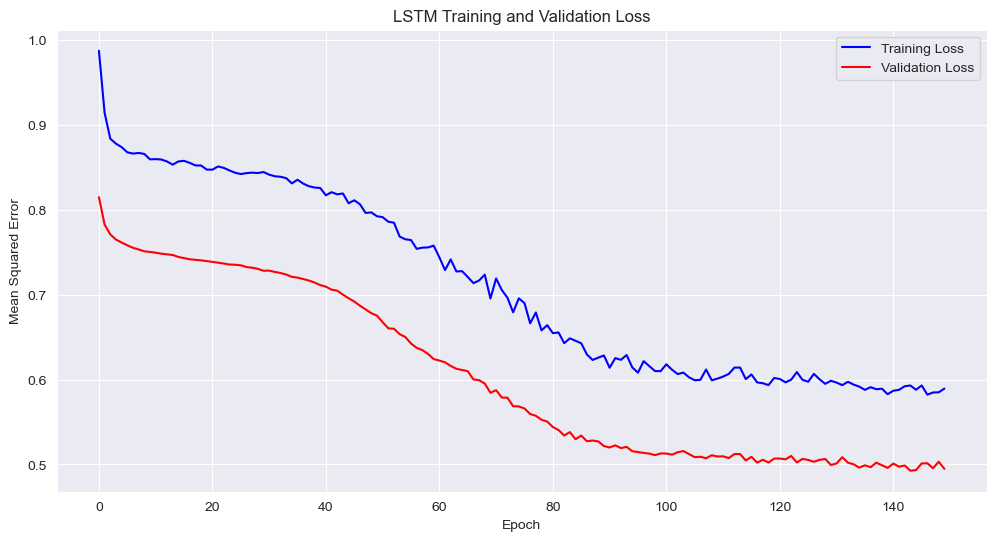

In [ ]:
# Assuming history is the result of your model training
history = model_r.history

# Plotting the training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.title('LSTM Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.savefig('LSTM Bike return validaton')
plt.show()

In [ ]:
model_r.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 1, 5)              340       
                                                                 
 dropout_4 (Dropout)         (None, 1, 5)              0         
                                                                 
 lstm_7 (LSTM)               (None, 1, 10)             640       
                                                                 
 lstm_8 (LSTM)               (None, 30)                4920      
                                                                 
 dense_4 (Dense)             (None, 10)                310       
                                                                 
 dense_5 (Dense)             (None, 11)                121       
                                                                 
Total params: 6331 (24.73 KB)
Trainable params: 6331 (

In [ ]:

y_pred_normalized = model_r.predict(X_test_reshaped)

# Inverting the normalization to get the actual values
y_pred = y_scaler_r.inverse_transform(y_pred_normalized)
y_test_actual = y_scaler_r.inverse_transform(y_test_normalized)

# Calculating RMSE for each target column
rmse_scores = {}
r2_scores={}
rmlse_score={}
for i in range(y_test_actual.shape[1]):

    rmse = np.sqrt(mean_squared_error(y_test_actual[:, i], y_pred[:, i]))
    column_name = y_test.columns[i]  # Assuming y_test has column names
    rmse_scores[column_name] = rmse

    # R-squared calculation
    r2 = r2_score(y_test_actual[:, i], y_pred[:, i])
    r2_scores[column_name] = r2

    # Ensure the actual and predicted values are positive
    y_test_actual_positive = np.abs(y_test_actual[:, i])
    y_pred_positive = np.abs(y_pred[:, i])
     # Calculate RMSLE
    rmlse = np.sqrt(mean_squared_log_error(y_test_actual_positive, y_pred_positive))
    column_name = y_test.columns[i]  # Assuming y_test has column names
    rmlse_scores[column_name] = rmlse

# Calculating the average RMSE
average_rmse = np.mean(list(rmse_scores.values()))

# Calculating the average R-squared
average_r2 = np.mean(list(r2_scores.values()))
# Calculating the average RMSLE
average_rmlse = np.mean(list(rmlse_scores.values()))

# Printing the RMSE and R-squared scores
for column in rmse_scores:
    print(f"RMSE for {column}: {rmse_scores[column]}")
for column in r2_scores:
    print(f"R-squared for {column}: {r2_scores[column]}")
for column in rmlse_scores:
    print(f"RMSLE for {column}: {rmlse_scores[column]}")

print(f'Average RMSE of LSTM for cluster 2 is {average_rmse}')
print(f'Average R-squared of LSTM for cluster 2 is {average_r2}')
print(f'Average RMSLE of LSTM for cluster 2 is {average_rmlse}')

20/20 [==============================] - 3s 6ms/step
RMSE for 641: 1.3424057192703995
RMSE for 2322: 1.3106180269255068
RMSE for 2313: 1.1449476770603115
RMSE for 75: 0.894843439911586
RMSE for 157: 1.5403434547557844
RMSE for 301: 1.2191899293933388
RMSE for 214: 1.3054897351477839
RMSE for 138: 1.7161747766299564
RMSE for 5: 1.1940361658685854
RMSE for 794: 1.6503012687910472
RMSE for 87: 1.226969099701952
R-squared for 641: 0.3534496901214801
R-squared for 2322: 0.6298354014526653
R-squared for 2313: 0.4138218173211795
R-squared for 75: 0.4223514088906597
R-squared for 157: 0.3427025709425404
R-squared for 301: 0.39032906126541633
R-squared for 214: 0.494313445593353
R-squared for 138: 0.5408493079776815
R-squared for 5: 0.36707164658812896
R-squared for 794: 0.4418828891535276
R-squared for 87: 0.3000229599439528
RMSLE for 641: 0.5433806474144797
RMSLE for 2322: 0.4588727139068688
RMSLE for 214: 0.49292910204982676
RMSLE for 157: 0.572451748797696
RMSLE for 301: 0.5091560290283148


In [ ]:

input_array = np.array([24,13, 10, 7.8,9.5,9.2,0,1.5,2.2,0.87,0])
#input_array = np.array([26,13,10, 5.3,7.1,7,0,0.4,1.4,0.54,0])
#input_array=np.array([24,14,10,10.0,12.6,12.6,0.1,8.2,12.6,0.62,0])

# Reshape and normalize the input
input_array = input_array.reshape(1, -1)  # Convert to 2D array
input_normalized = X_scaler.transform(input_array)
input_normalized_r = X_scaler_r.transform(input_array)
input_reshaped = input_normalized.reshape(1, 1, input_normalized.shape[1])
input_reshaped_r = input_normalized_r.reshape(1, 1, input_normalized.shape[1])

# Use the model to predict the output
predicted_normalized = model.predict(input_reshaped)
predicted_r_normalized = model_r.predict(input_reshaped_r)

# Inverse transform the prediction to get it on the original scale
predicted_output = y_scaler.inverse_transform(predicted_normalized)
predicted_r_output = y_scaler_r.inverse_transform(predicted_r_normalized)

# Round the predictions to the nearest integer
rounded_predictions = np.round(predicted_output)
rounded_r_predictions = np.round(predicted_r_output)

# Convert to DataFrame with column names for better readability
predicted_df = pd.DataFrame(rounded_predictions, columns=y.columns)#####################
predicted_r_df = pd.DataFrame(rounded_r_predictions, columns=y_r.columns)##################


1/1 [==============================] - 0s 18ms/step


In [ ]:
predicted_df[[5, 75, 87, 138, 157, 214, 301, 641, 794, 2313, 2322]]

,5,75,87,138,157,214,301,641,794,2313,2322
0,4.0,3.0,3.0,6.0,6.0,6.0,4.0,4.0,8.0,5.0,5.0


In [ ]:

    5	75	87	138	157	214	301	641	794	2313	2322
0	3.0	4.0	3.0	7.0	5.0	6.0	4.0	4.0	8.0	5.0	5.0

In [ ]:
october_test_1[(october_test_1["started_date"]=="2023-10-24")& (october_test_1["started_hour"]==13)][[5, 75, 87, 138, 157, 214, 301, 641, 794, 2313, 2322]]

,5,75,87,138,157,214,301,641,794,2313,2322
17112,9,7,2,3,4,7,6,5,12,4,5


In [ ]:
predicted_r_df[[5, 75, 87, 138, 157, 214, 301, 641, 794, 2313, 2322]]


,5,75,87,138,157,214,301,641,794,2313,2322
0,-1.0,-1.0,-2.0,-2.0,-2.0,-1.0,-2.0,-2.0,-3.0,-2.0,-1.0


In [ ]:
october_r_test_1[(october_r_test_1["ended_date"]=="2023-10-24")& (october_r_test_1["ended_hour"]==13)][[5, 75, 87, 138, 157, 214, 301, 641, 794, 2313, 2322]]

,5,75,87,138,157,214,301,641,794,2313,2322
16786,-2,-3,-6,-3,-5,-1,-4,-2,-6,0,-1


In [ ]:
lstm_dict = predicted_df.iloc[0].to_dict()
lstm_r_dict=predicted_r_df.iloc[0].to_dict()

# Print the dictionary
print(lstm_dict)
print(lstm_r_dict)

{641: 4.0, 2322: 5.0, 214: 6.0, 157: 6.0, 301: 4.0, 87: 3.0, 75: 3.0, 2313: 5.0, 5: 4.0, 794: 8.0, 138: 6.0}
{641: -2.0, 2322: -1.0, 2313: -2.0, 75: -1.0, 157: -2.0, 301: -2.0, 214: -1.0, 138: -2.0, 5: -1.0, 794: -3.0, 87: -2.0}


# Ground Truth

In [ ]:

original_dict=october_test_1[(october_test_1["started_date"]=="2023-10-24")& (october_test_1["started_hour"]==13)][[5, 75, 87, 138, 157, 214, 301, 641, 794, 2313, 2322]].to_dict()
original_dict={key: list(inner_dict.values())[0] for key, inner_dict in original_dict.items()}
original_r_dict=october_r_test_1[(october_r_test_1["ended_date"]=="2023-10-24")& (october_r_test_1["ended_hour"]==13)][[5, 75, 87, 138, 157, 214, 301, 641, 794, 2313, 2322]].to_dict()
original_r_dict={key: list(inner_dict.values())[0] for key, inner_dict in original_r_dict.items()}

In [ ]:
print(original_dict)
print(original_r_dict)

{5: 9, 75: 7, 87: 2, 138: 3, 157: 4, 214: 7, 301: 6, 641: 5, 794: 12, 2313: 4, 2322: 5}
{5: -2, 75: -3, 87: -6, 138: -3, 157: -5, 214: -1, 301: -4, 641: -2, 794: -6, 2313: 0, 2322: -1}


# 7 days average

In [ ]:
###################################  For pickup
def get_averages(final_df, interval_days=6, points=7):
    averages_dict = {}

    # Ensure the DataFrame index is a DatetimeIndex for manipulation
    final_df.index = pd.to_datetime(final_df.index)

    # Find the last date and hour in the dataframe
    last_date = final_df.index[-1]
    last_hour = final_df.iloc[-1]['started_hour'] + 2             ## for 2 hours later

    # Find the datetime rows that correspond to the last few points of interest
    selected_rows = pd.DataFrame()
    for i in range(1,points+1):
        # Calculate the date to look back to
        date_to_look = last_date - pd.Timedelta(days=interval_days * i)
        # Find rows matching the exact date and hour (or closest to it)
        temp_df = final_df[(final_df.index.date == date_to_look.date()) & (final_df['started_hour'] == last_hour)]
        if not temp_df.empty:
            selected_rows = pd.concat([selected_rows, temp_df])

    # If no rows have been selected, return an empty dictionary
    if selected_rows.empty:
        return averages_dict

    # Calculate the average for each column from the 11th column onwards
    for col in final_df.columns[11:]:  # assuming the 'started_hour' is the 10th column
        averages_dict[col] = math.ceil(selected_rows[col].mean())

    return averages_dict

####################For return

def get_averages_r(final_df, interval_days=6, points=7):
    averages_dict = {}

    # Ensure the DataFrame index is a DatetimeIndex for manipulation
    final_df.index = pd.to_datetime(final_df.index)

    # Find the last date and hour in the dataframe
    last_date = final_df.index[-1]
    last_hour = final_df.iloc[-1]['ended_hour'] + 2             ## for 2 hours later

    # Find the datetime rows that correspond to the last few points of interest
    selected_rows = pd.DataFrame()
    for i in range(1,points+1):
        # Calculate the date to look back to
        date_to_look = last_date - pd.Timedelta(days=interval_days * i)
        # Find rows matching the exact date and hour (or closest to it)
        temp_df = final_df[(final_df.index.date == date_to_look.date()) & (final_df['ended_hour'] == last_hour)]
        if not temp_df.empty:
            selected_rows = pd.concat([selected_rows, temp_df])

    # If no rows have been selected, return an empty dictionary
    if selected_rows.empty:
        return averages_dict

    # Calculate the average for each column from the 11th column onwards
    for col in final_df.columns[11:]:  # assuming the 'started_hour' is the 10th column
        averages_dict[col] = math.ceil(selected_rows[col].mean())

    return averages_dict


In [ ]:
average_dict=get_averages(final_df)
average_r_dict=get_averages_r(final_r_df)
print(average_dict)
print(average_r_dict)

{641: 4, 2322: 3, 214: 5, 157: 7, 301: 3, 87: 3, 75: 2, 2313: 4, 5: 2, 794: 5, 138: 4}
{641: -1, 2322: 0, 2313: 0, 75: 0, 157: -1, 301: -2, 214: 0, 138: -2, 5: -1, 794: -2, 87: -2}


# <span style="color: black; font-family: Oswald ;">*Function for Demand & Distance calculation*</span>
### <font color='black'>(Using Cluster 2 in both pickups and returns) </font>

In [ ]:

# Adjusting stations prediction of pickups and returns to find exact repositioning

def reposition(positive_demand:dict,negative_demand:dict,P_s=1, C_s=7):

    t_s = {}

    # Adjusting for common stations
    common_stations = set(positive_demand.keys()).intersection(negative_demand.keys())
    for station in common_stations:
        net_demand = positive_demand[station] + negative_demand[station]
        if net_demand >= 0 and net_demand > P_s:
            ta = net_demand - P_s
            t_s[station] = ta

        elif net_demand<0 and abs(net_demand)>(C_s - P_s):
            tr = (C_s - P_s) + net_demand
            t_s[station] = tr

    return t_s
#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

# Defining dataframe of the repositioning stations with 0 as depot

def distance_dataframe(df:pd.DataFrame, prediction:dict):
    rows = []
    station_ids = list(prediction.keys())

    for station_id in station_ids:
        matched_row = df[df['start_station_id'] == station_id].iloc[0]
        rows.append({
            "Station ID": station_id,
            "Station Name": matched_row['start_station_name'],
            "Latitude": matched_row['start_station_latitude'],
            "Longitude": matched_row['start_station_longitude']
            })

    # Geographic location of depot
    depot = {
        "Station ID": 0,
        "Station Name": "Fabrikkgaten 7",
        "Latitude": 60.371615715849515,
        "Longitude": 5.3446761199126716
        }

    distance_df = pd.DataFrame([depot] + rows)

    return distance_df
#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

# Calculating distance matrix between the repositioning stations.

def create_distance_matrix(df:pd.DataFrame)->pd.DataFrame:
    # Add coordinates as a tuple of (latitude, longitude)
    df['coords'] = list(zip(df['Latitude'], df['Longitude']))

    # Create the road network (adjust the location as needed)
    graph = ox.graph_from_place('Bergen, Norway', network_type='drive')  # Replace with the actual location

    # Function to compute the distance between two points
    def compute_distance(coords1, coords2):
        node1 = ox.distance.nearest_nodes(graph, X=coords1[1], Y=coords1[0])
        node2 = ox.distance.nearest_nodes(graph, X=coords2[1], Y=coords2[0])

        try:
            distance = nx.shortest_path_length(graph, source=node1, target=node2, weight='length')
            return distance
        except nx.NetworkXNoPath:
            return float('inf')  # If no path is found, return infinity

    # Initialize an empty DataFrame for the distance matrix
    distance_matrix = pd.DataFrame(index=df['Station ID'], columns=df['Station ID'])

    # Fill the distance matrix
    for i in df['Station ID']:
        for j in df['Station ID']:
            if i != j:
                distance_matrix.loc[i, j] = compute_distance(
                    df[df['Station ID'] == i]['coords'].values[0],
                    df[df['Station ID'] == j]['coords'].values[0]
                )
            else:
                distance_matrix.loc[i, j] = 0

    # Convert the distance matrix to the desired format (e.g., floats)
    return distance_matrix.astype(float)

# Usage
#distance_matrix_lstm = create_distance_matrix(distance_lstm)
#print(distance_matrix_lstm)


## For  <font color='red'>*XGboost*</font>

In [ ]:
pde_xg = xg_dict # positive demand dictionary of xgboost model
nde_xg = xg_r_dict # negative demand dictionary of xgboost model

xg_reposition = reposition(pde_xg,nde_xg)

distance_df_xg=distance_dataframe(may, xg_reposition)

distance_matrix_xg=create_distance_matrix(distance_df_xg)

In [ ]:
xg_reposition

{641: 2, 2313: 3, 138: 2, 75: 2, 301: 1, 2322: 2, 214: 3, 794: 3, 157: 2}

In [ ]:
{2322: 5, 641: 5, 138: 6, 794: 7, 214: 5, 75: 4, 157: 5, 87: 3, 2313: 6, 5: 2, 301: 4}
{157: -2, 138: -3, 214: -1, 87: -2, 2322: -2, 301: -2, 2313: -2, 794: -3, 5: -1, 641: -2, 75: -1}

In [ ]:
distance_matrix_xg

Station ID,0,641,2313,138,75,301,2322,214,794,157
Station ID,,,,,,,,,,
0,0.000,2018.658,1542.615,4429.347,4659.487,2287.471,1710.712,2072.321,2231.540,1705.347
641,1350.014,0.000,547.323,3947.791,4177.931,1805.915,1229.156,1669.142,1749.984,1223.791
2313,1161.841,509.221,0.000,3400.468,3630.608,1258.592,681.833,1480.969,1202.661,676.468
138,4431.196,3871.545,3362.324,0.000,603.694,2327.639,2777.710,3013.578,2280.010,2772.345
75,4704.818,4145.167,3635.946,603.694,0.000,2601.261,3051.332,3287.200,2553.632,3045.967
301,2355.914,1879.389,1660.006,2226.720,2456.860,0.000,1898.839,685.939,1401.139,1893.474
2322,1725.893,1166.242,657.021,2834.279,3064.419,692.403,0.000,1378.342,636.472,11.891
214,3844.115,2672.113,2874.915,3159.140,3432.762,2846.922,2217.894,0.000,2799.293,2229.785
794,2271.216,1711.565,1202.344,2197.807,2427.947,179.637,617.730,865.576,0.000,612.365


In [ ]:
distance_matrix_xg.at[138,2313]

3362.3239999999996

## For  <font color='red'>*XGboost with Metaheuristic hyperparameter tuning*</font>

In [ ]:
pde_xg_m = m_xg_dict # positive demand dictionary of xgboost model
nde_xg_m= m_r_xg_dict

xg_reposition_m = reposition(pde_xg_m,nde_xg_m)

distance_df_xg_m=distance_dataframe(may, xg_reposition_m)

distance_matrix_xg_m=create_distance_matrix(distance_df_xg_m)

In [ ]:
xg_reposition_m

{641: 3, 2313: 2, 138: 2, 75: 2, 301: 1, 214: 3, 794: 2, 157: 1}

## For <font color='red'>*LSTM*</font>

In [ ]:
pde_lstm = lstm_dict  # positive demand dictionary of lstm model
nde_lstm = lstm_r_dict # negative demand dictionary of lstm model

lstm_reposition = reposition(pde_lstm,nde_lstm)

distance_df_lstm=distance_dataframe(may, lstm_reposition)

distance_matrix_lstm=create_distance_matrix(distance_df_lstm)

In [ ]:
lstm_reposition

{641: 2.0,
 5: 2.0,
 2313: 3.0,
 138: 4.0,
 75: 2.0,
 301: 1.0,
 2322: 3.0,
 214: 4.0,
 794: 4.0,
 157: 2.0}

In [ ]:
nde_lstm

{157: -2.0,
 138: -3.0,
 214: -2.0,
 87: -2.0,
 2322: -2.0,
 301: -2.0,
 2313: -2.0,
 794: -3.0,
 5: -2.0,
 641: -2.0,
 75: -1.0}

## For  <font color='red'>*Ground truth*</font>

In [ ]:
pde_or = original_dict # positive demand dictionary of ground truth
nde_or = original_r_dict # negative demand dictionary of ground truth

original_reposition = reposition(pde_or,nde_or)

distance_df_or=distance_dataframe(may, original_reposition)

distance_matrix_or=create_distance_matrix(distance_df_or)

In [ ]:
original_reposition

{641: 2, 5: 6, 2313: 3, 75: 3, 301: 1, 2322: 3, 214: 5, 794: 5}

## For  <font color='red'>*5 days average of the predictive hour*</font>

In [ ]:

pde_average = average_dict # positive demand dictionary
nde_average=average_r_dict # negative demand dictionary

average_reposition = reposition(pde_average,nde_average)

distance_df_average=distance_dataframe(may, average_reposition)

distance_matrix_average=create_distance_matrix(distance_df_average)




In [ ]:
average_reposition

{641: 2, 2313: 3, 138: 1, 75: 1, 2322: 2, 214: 4, 794: 2, 157: 5}

# Demand Sensing (to account recent event)

#  <span style="color: black; font-family: Oswald ;">*Mixed Integer Non-Linear Programing*</span>

In [ ]:
def routing_optimization(
    s_0: list, s_1: list, T_s: dict, d: pd.DataFrame, a: list,
    P_s: int = 1, Q: int = 20, U: int = 39, K: int = 0.14,
    C_s: int = 7, M: int = 1000, lambda_v: float = 0.009
):


    m=gp.Model('BikeRepositioning')
    m.reset()
    x=m.addVars(s_0,a,vtype=GRB.BINARY,name="x")
    y=m.addVars(s_0,a,lb=-GRB.INFINITY,vtype=GRB.INTEGER,name="y")
    b=m.addVars(s_1,vtype=GRB.INTEGER, name="b")
    i=m.addVars(s_0,a,lb=0,vtype=GRB.INTEGER, name="i")
    n= m.addVars(a, lb=0, vtype=GRB.INTEGER, name="n")
    r=m.addVars(s_1,vtype=GRB.BINARY,name="r")



    # Constraints

    #1 each stop for 1 station
    for stop in a:
        m.addConstr(gp.quicksum(x[s,stop] for s in s_0)==1, name=f"OneStationAtStop_{stop}")

    #2 first stop at depot
    m.addConstr(x[0,1]==1,name="FirstStopDepot")
    #3 last stop at depot
    m.addConstr(x[0,max(a)]==1,name="LastStopDepot")
    #4
    for s in s_0:
        for idx in range(0, len(a) - 1):  # Avoid the last element for this loop
            m.addConstr(x[s, a[idx]] + x[s, a[idx+1]] <= 1, name=f"NoConsecutiveStop_s{s}_a{a[idx]}_a{a[idx+1]}")


    #5 bikes add or remove only when vehicle visited
    for s in s_0:
        for stop in a:
            m.addConstr(y[s,stop]>=-Q * x[s,stop])
            m.addConstr(y[s,stop]<= Q * x[s,stop])
    #6 balance the number of bike on the vehicle
    for stop in range(2, len(a)+1):
        m.addConstr(n[stop]==n[stop-1]-gp.quicksum(y[s,stop] for s in s_0))
    #7 initial bike on vehicle is same as number of bikes from first stop or depot
    m.addConstr(n[1]==-y[0,1])
    #8 Balance the number of bike at specific station
    for s in s_0:
        for stop in a[1:]:
            m.addConstr(i[s,stop]==i[s,stop-1]+y[s,stop],name=f"balance_bikes_station_{s}_stop_{stop}")
    #9 Initial number of bikes of each station
    for s in s_1:
        m.addConstr(i[s,1]==P_s,name=f"initial_bikes_station_{s}")
    #10 total bike to be repositioned
    for s in s_1:
        m.addConstr(b[s]==gp.quicksum(y[s,stop]for stop in a),name=f"TotalBikeRepositionInStaiton_{s}")
    #11 Vehicle capacity
    for stop in a:
        m.addConstr(n[stop] >= 0, name=f"vehicle_capacity_lb_{stop}")
        m.addConstr(n[stop] <= Q, name=f"vehicle_capacity_ub_{stop}")

    #12 Station capacity
    for s in s_1:
        for stop in a:
            m.addConstr(i[s,stop] >= 0, name=f"station_capacity_lb_{s}_{stop}")
            m.addConstr(i[s,stop] <= C_s, name=f"station_capacity_ub_{s}_{stop}")

    #13  ++++++++++++++++++++++++++++++++++++++++

    t = [value for value in T_s.values()]
    total_target_reposition = sum(t)

    if total_target_reposition > 0:
        m.addConstr(y[0, max(a)] == 0)
        m.addConstr(n[max(a)]==0) ################## new development
    else:
        m.addConstr(y[0,max(a)]>=0)

    #17(1) implication of strategy to go to positive demand stations earlier
    for s in s_1:
        for stop in a:
            m.addConstr(T_s[s] * x[s,stop]<= M * r[s],name=f"pos_demand_check_{s}_{stop}")
    #17(2) implication of strategy to go to positive demand stations earlier
    for s in s_1:
        for stop in a:
            g=m.addConstr(T_s[s]*x[s,stop]>=-M*(1-r[s]),name=f"neg_demand_check_{s}_{stop}")

    #18  Should Start with atleast 2 bikes from depot
    m.addConstr(y[0, 1] <= -2, name="remove_2_or_more_from_depot_at_first_stop")

    #Objective Function
    travel_cost=  gp.quicksum(K*d.at[s,j]*x[s,stop-1]*x[j,stop] for s in s_0 for j in s_0 for stop in a[1:])
    penalty_1=gp.quicksum(U*((T_s[s]-b[s])*(T_s[s]-b[s])) for s in s_1)
    penalty_2=gp.quicksum(lambda_v * r[s]*stop*x[s,stop] for s in s_1 for stop in a[1:])
    obj= travel_cost + penalty_1 #+ penalty_2
    m.setObjective(obj,GRB.MINIMIZE)
    m.optimize()

    if m.status == GRB.OPTIMAL:

        print(f"Optimized travel cost: {travel_cost.getValue()}")
        print(f"Optimized penalty 1 (unsatisfied demand): {penalty_1.getValue()}")
        print(f"Optimized penalty 2 (regulation): {penalty_2.getValue()}")
    else:
        print("No optimal solution found.")

    return m
    return travel_cost.getValue()

 # +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

def display_optimization(model, s_0, model_name, a: list):
    if model.status == GRB.Status.OPTIMAL:
        print(f"Using {model_name} for optimization")
        print("Objective Value:", model.objVal)

        optimal_sequence = []
        solution_values = []

        for stop in a:
            for s in s_0:
                var_name = f"x[{s},{stop}]"  # Construct the variable name
                var = model.getVarByName(var_name)  # Retrieve the variable from the model
                if var.X > 0.5:  # Check if the variable is set to 1 in the solution
                    optimal_sequence.append((s, stop))
                    solution_values.append(var.X)
                    break  # Only the first match for each stop is needed

        print("Optimal sequence of nodes with stops:", optimal_sequence)
        #print("Solution values for the optimal sequence:", solution_values)

        print("Number of bikes added or removed at each stop in the optimal solution:")
        for s, stop in optimal_sequence:
            var_name = f"y[{s},{stop}]"
            change_in_bikes = model.getVarByName(var_name).X
            if change_in_bikes > 0:
                print(f"At station {s}, stop {stop}: {change_in_bikes} bikes were added.")
            elif change_in_bikes < 0:
                print(f"At station {s}, stop {stop}: {-change_in_bikes} bikes were removed.")
            else:
                print(f"At station {s}, stop {stop}: No bikes were added or removed.")
    else:
        print("Model wasn't solved to optimality. Check the status.")

#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++



In [ ]:
# Different number of stops. Similar for all models.
a_3=list(range(1,4))
a_4=list(range(1,5))
a_5=list(range(1,6))
a_6=list(range(1,7))
a_7=list(range(1,8))
a_8=list(range(1,9))


In [ ]:
# xgboost
s_0_xg= list(distance_df_xg['Station ID']) #[0,814, 138, 36, 794, 157, 220, 789, 641]
s_1_xg=list(xg_reposition.keys())



# Parameters
P_s,Q,U,K,C_s= 1,20,39,0.014,7
T_s_xg = xg_reposition #{814: 4.0, 138: 1.0, 36: 3.0, 794: 2.0, 157: 2.0, 220: 4.0, 789: 3.0, 641: -2}

M=1000
lambda_v=0.009

In [ ]:
xg_optimization_3 = routing_optimization(s_0_xg,s_1_xg,T_s_xg,distance_matrix_xg,a_3)
xg_optimization_4 = routing_optimization(s_0_xg,s_1_xg,T_s_xg,distance_matrix_xg,a_4)
xg_optimization_5 = routing_optimization(s_0_xg,s_1_xg,T_s_xg,distance_matrix_xg,a_5)
xg_optimization_6 = routing_optimization(s_0_xg,s_1_xg,T_s_xg,distance_matrix_xg,a_6)
xg_optimization_7 = routing_optimization(s_0_xg,s_1_xg,T_s_xg,distance_matrix_xg,a_7)
xg_optimization_8 = routing_optimization(s_0_xg,s_1_xg,T_s_xg,distance_matrix_xg,a_8)


Discarded solution information
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-6300U CPU @ 2.40GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 243 rows, 111 columns and 494 nonzeros
Model fingerprint: 0x414692f2
Model has 189 quadratic objective terms
Variable types: 0 continuous, 111 integer (39 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [8e+01, 2e+02]
  QObjective range [3e+00, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
Presolve removed 233 rows and 93 columns
Presolve time: 0.03s
Presolved: 10 rows, 18 columns, 35 nonzeros
Presolved model has 9 quadratic objective terms
Variable types: 0 continuous, 18 integer (8 binary)
Found heuristic solution: objective 2055.6238400

Root relaxation: objective 1.433129e+03, 18 iterations, 0.01 seconds (0.00 work units)

    Nodes    |    Current 

H    0     0                    2375.8828400    0.00000   100%     -    0s
     0     0 -5513.4003    0  107 2375.88284    0.00000   100%     -    0s
H    0     0                    2219.8828400    0.00000   100%     -    0s
     0     2 -5513.4003    0  107 2219.88284    0.00000   100%     -    0s
H   32    36                    2215.9835200    0.00000   100%   5.6    0s
H   32    36                    1989.1751600    0.00000   100%   5.6    0s
H   58    56                    1870.2827200    0.00000   100%   5.1    0s
H   99    91                    1684.7340200    0.00000   100%   5.1    0s
H  196   110                    1584.2201800    0.00000   100%   5.6    0s
*  215   126              25    1570.4458600    0.00000   100%   5.6    0s
*  372   206              26    1513.4573200    0.00000   100%   5.5    0s
* 1298   455              24    1511.5384800    0.00000   100%   5.5    0s

Cutting planes:
  Implied bound: 18
  MIR: 1

Explored 3743 nodes (20155 simplex iterations) in 0.7

In [ ]:
xg_display_3=display_optimization(xg_optimization_3,s_0_xg,'XGboost prediction with 3 stops', a_3)   # optimization for 3 stops
xg_display_4=display_optimization(xg_optimization_4,s_0_xg,'XGboost prediction with 4 stops', a_4)   # optimization for 4 stops
xg_display_5=display_optimization(xg_optimization_5,s_0_xg,'XGboost prediction with 5 stops', a_5)   # optimization for 5 stops
xg_display_6=display_optimization(xg_optimization_6,s_0_xg,'XGboost prediction with 6 stops', a_6)   # optimization for 6 stops
xg_display_7=display_optimization(xg_optimization_7,s_0_xg,'XGboost prediction with 7 stops',a_7)    # optimization for 7 stops
xg_display_8=display_optimization(xg_optimization_8,s_0_xg,'XGboost prediction with 8 stops', a_8)   # optimization for 8 stops

Using XGboost prediction with 3 stops for optimization
Objective Value: 1899.62384
Optimal sequence of nodes with stops: [(0, 1), (2313, 2), (0, 3)]
Number of bikes added or removed at each stop in the optimal solution:
At station 0, stop 1: 3.0 bikes were removed.
At station 2313, stop 2: 3.0 bikes were added.
At station 0, stop 3: No bikes were added or removed.
Using XGboost prediction with 4 stops for optimization
Objective Value: 1813.4015000000002
Optimal sequence of nodes with stops: [(0, 1), (794, 2), (2313, 3), (0, 4)]
Number of bikes added or removed at each stop in the optimal solution:
At station 0, stop 1: 6.0 bikes were removed.
At station 794, stop 2: 3.0 bikes were added.
At station 2313, stop 3: 3.0 bikes were added.
At station 0, stop 4: No bikes were added or removed.
Using XGboost prediction with 5 stops for optimization
Objective Value: 1665.12264
Optimal sequence of nodes with stops: [(0, 1), (794, 2), (157, 3), (2313, 4), (0, 5)]
Number of bikes added or removed 

In [ ]:
# xgboost
s_0_xg_m= list(distance_df_xg_m['Station ID']) #[0,814, 138, 36, 794, 157, 220, 789, 641]
s_1_xg_m=list(xg_reposition_m.keys())



# Parameters
P_s,Q,U,K,C_s= 1,20,39,0.014,7
T_s_xg_m = xg_reposition_m #{814: 4.0, 138: 1.0, 36: 3.0, 794: 2.0, 157: 2.0, 220: 4.0, 789: 3.0, 641: -2}

M=1000
lambda_v=0.009

In [ ]:
xg_optimization_3_m = routing_optimization(s_0_xg_m,s_1_xg_m,T_s_xg_m,distance_matrix_xg_m,a_3)
xg_optimization_4_m = routing_optimization(s_0_xg_m,s_1_xg_m,T_s_xg_m,distance_matrix_xg_m,a_4)
xg_optimization_5_m = routing_optimization(s_0_xg_m,s_1_xg_m,T_s_xg_m,distance_matrix_xg_m,a_5)
xg_optimization_6_m = routing_optimization(s_0_xg_m,s_1_xg_m,T_s_xg_m,distance_matrix_xg_m,a_6)
xg_optimization_7_m = routing_optimization(s_0_xg_m,s_1_xg_m,T_s_xg_m,distance_matrix_xg_m,a_7)
xg_optimization_8_m = routing_optimization(s_0_xg_m,s_1_xg_m,T_s_xg_m,distance_matrix_xg_m,a_8)

Discarded solution information
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-6300U CPU @ 2.40GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 219 rows, 100 columns and 444 nonzeros
Model fingerprint: 0x78d50468
Model has 152 quadratic objective terms
Variable types: 0 continuous, 100 integer (35 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [8e+01, 2e+02]
  QObjective range [5e+01, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
Found heuristic solution: objective 2054.0739000
Presolve removed 210 rows and 84 columns
Presolve time: 0.00s
Presolved: 9 rows, 16 columns, 31 nonzeros
Presolved model has 8 quadratic objective terms
Variable types: 0 continuous, 16 integer (7 binary)

Root relaxation: objective 1.125353e+03, 20 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current N

H    0     0                    2258.8828400    0.00000   100%     -    0s
     0     0 -4921.5656    0   87 2258.88284    0.00000   100%     -    0s
H    0     0                    1907.8828400    0.00000   100%     -    0s
     0     0 -4921.5656    0   87 1907.88284    0.00000   100%     -    0s
H    0     0                    1751.8828400    0.00000   100%     -    0s
H    0     0                    1632.0827600    0.00000   100%     -    0s
     0     2 -4921.5656    0   87 1632.08276    0.00000   100%     -    0s
H   58    50                    1619.0671000    0.00000   100%   5.1    0s
H  139   104                    1580.0671000    0.00000   100%   5.2    0s
*  182   110              14    1536.6561800    0.00000   100%   5.4    0s
*  202   135              15    1436.9750200    0.00000   100%   5.4    0s

Cutting planes:
  Implied bound: 10
  MIR: 2

Explored 2814 nodes (15308 simplex iterations) in 0.80 seconds (0.19 work units)
Thread count was 4 (of 4 available processors)


In [ ]:
xg_display_3_m=display_optimization(xg_optimization_3_m,s_0_xg_m,'XGboost_m prediction with 3 stops', a_3)   # optimization for 3 stops
xg_display_4_m=display_optimization(xg_optimization_4_m,s_0_xg_m,'XGboost_m prediction with 4 stops', a_4)   # optimization for 4 stops
xg_display_5_m=display_optimization(xg_optimization_5_m,s_0_xg_m,'XGboost_m prediction with 5 stops', a_5)   # optimization for 5 stops
xg_display_6_m=display_optimization(xg_optimization_6_m,s_0_xg_m,'XGboost_m prediction with 6 stops', a_6)   # optimization for 6 stops
xg_display_7_m=display_optimization(xg_optimization_7_m,s_0_xg_m,'XGboost_m prediction with 7 stops',a_7)    # optimization for 7 stops
xg_display_8_m=display_optimization(xg_optimization_8_m,s_0_xg_m,'XGboost_m prediction with 8 stops', a_8)   # optimization for 8 stops

Using XGboost_m prediction with 3 stops for optimization
Objective Value: 1524.61408
Optimal sequence of nodes with stops: [(0, 1), (641, 2), (0, 3)]
Number of bikes added or removed at each stop in the optimal solution:
At station 0, stop 1: 3.0 bikes were removed.
At station 641, stop 2: 3.0 bikes were added.
At station 0, stop 3: No bikes were added or removed.
Using XGboost_m prediction with 4 stops for optimization
Objective Value: 1373.259
Optimal sequence of nodes with stops: [(0, 1), (2313, 2), (641, 3), (0, 4)]
Number of bikes added or removed at each stop in the optimal solution:
At station 0, stop 1: 5.0 bikes were removed.
At station 2313, stop 2: 2.0 bikes were added.
At station 641, stop 3: 3.0 bikes were added.
At station 0, stop 4: No bikes were added or removed.
Using XGboost_m prediction with 5 stops for optimization
Objective Value: 1423.5400000000002
Optimal sequence of nodes with stops: [(0, 1), (2313, 2), (641, 3), (2313, 4), (0, 5)]
Number of bikes added or remov

In [ ]:
# LSTM
s_0_ls= list(distance_df_lstm['Station ID']) #[0,814, 138, 36, 794, 157, 220, 789, 641]
s_1_ls=list(lstm_reposition.keys())


# Parameters
P_s,Q,U,K,C_s= 1,20,39,0.014,7
T_s_lstm = lstm_reposition #{814: 4.0, 138: 1.0, 36: 3.0, 794: 2.0, 157: 2.0, 220: 4.0, 789: 3.0, 641: -2}

M=1000
lambda_v=0.009



In [ ]:
lstm_optimization_3 = routing_optimization(s_0_ls,s_1_ls,T_s_lstm,distance_matrix_lstm,a_3)  # optimization for 3 stops
lstm_optimization_4 = routing_optimization(s_0_ls,s_1_ls,T_s_lstm,distance_matrix_lstm,a_4)  # optimization for 4 stops
lstm_optimization_5 = routing_optimization(s_0_ls,s_1_ls,T_s_lstm,distance_matrix_lstm,a_5)  # optimization for 5 stops
lstm_optimization_6 = routing_optimization(s_0_ls,s_1_ls,T_s_lstm,distance_matrix_lstm,a_6)  # optimization for 6 stops
lstm_optimization_7 = routing_optimization(s_0_ls,s_1_ls,T_s_lstm,distance_matrix_lstm,a_7)  # optimization for 7 stops
lstm_optimization_8 = routing_optimization(s_0_ls,s_1_ls,T_s_lstm,distance_matrix_lstm,a_8)  # optimization for 8 stops

Discarded solution information
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-6300U CPU @ 2.40GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 267 rows, 122 columns and 544 nonzeros
Model fingerprint: 0xf48bf8f4
Model has 230 quadratic objective terms
Variable types: 0 continuous, 122 integer (43 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [8e+01, 3e+02]
  QObjective range [3e+00, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
Presolve removed 256 rows and 102 columns
Presolve time: 0.00s
Presolved: 11 rows, 20 columns, 39 nonzeros
Presolved model has 10 quadratic objective terms
Variable types: 0 continuous, 20 integer (9 binary)
Found heuristic solution: objective 3303.6238400

Root relaxation: objective 2.022785e+03, 25 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Curren

 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 -6017.8521    0  117 3782.41654    0.00000   100%     -    0s
H    0     0                    3346.1767200    0.00000   100%     -    0s
H    0     0                    3013.4004200    0.00000   100%     -    0s
     0     0 -6000.0010    0  117 3013.40042    0.00000   100%     -    0s
H    0     0                    2897.5165800    0.00000   100%     -    0s
H    0     0                    2546.5165800    0.00000   100%     -    0s
     0     0 -5994.2457    0  119 2546.51658    0.00000   100%     -    0s
H    0     0                    2445.2021200    0.00000   100%     -    0s
H    0     0                    2352.9958600    0.00000   100%     -    0s
     0     2 -5994.2457    0  119 2352.99586    0.00000   100%     -    0s
H   29    36                    2313.9958600    0.00000   100%   4.9    0s
H   58    61                    2274.9958600    0.00000   100%   5.4    0s
H  140   125          

In [ ]:
lstm_display_3=display_optimization(lstm_optimization_3,s_0_ls,'LSTM prediction with 3 stops', a_3)   # optimization for 3 stops
lstm_display_4=display_optimization(lstm_optimization_4,s_0_ls,'LSTM prediction with 4 stops', a_4)   # optimization for 4 stops
lstm_display_5=display_optimization(lstm_optimization_5,s_0_ls,'LSTM prediction with 5 stops', a_5)   # optimization for 5 stops
lstm_display_6=display_optimization(lstm_optimization_6,s_0_ls,'LSTM prediction with 6 stops', a_6)   # optimization for 6 stops
lstm_display_7=display_optimization(lstm_optimization_7,s_0_ls,'LSTM prediction with 7 stops',a_7)    # optimization for 7 stops
lstm_display_8=display_optimization(lstm_optimization_8,s_0_ls,'LSTM prediction with 8 stops', a_8)   # optimization for 8 stops

Using LSTM prediction with 3 stops for optimization
Objective Value: 2736.38584
Optimal sequence of nodes with stops: [(0, 1), (794, 2), (0, 3)]
Number of bikes added or removed at each stop in the optimal solution:
At station 0, stop 1: 4.0 bikes were removed.
At station 794, stop 2: 4.0 bikes were added.
At station 0, stop 3: No bikes were added or removed.
Using LSTM prediction with 4 stops for optimization
Objective Value: 2393.10698
Optimal sequence of nodes with stops: [(0, 1), (794, 2), (157, 3), (0, 4)]
Number of bikes added or removed at each stop in the optimal solution:
At station 0, stop 1: 7.0 bikes were removed.
At station 794, stop 2: 4.0 bikes were added.
At station 157, stop 3: 3.0 bikes were added.
At station 0, stop 4: No bikes were added or removed.
Using LSTM prediction with 5 stops for optimization
Objective Value: 2044.5228200000004
Optimal sequence of nodes with stops: [(0, 1), (794, 2), (2322, 3), (157, 4), (0, 5)]
Number of bikes added or removed at each stop 

In [ ]:
# original

s_0_or= list(distance_df_or['Station ID']) #[0,814, 138, 36, 794, 157, 220, 789, 641]
s_1_or=list(original_reposition.keys())

# Parameters
P_s,Q,U,K,C_s= 1,20,39,0.014,7
T_s_or = original_reposition #{814: 4.0, 138: 1.0, 36: 3.0, 794: 2.0, 157: 2.0, 220: 4.0, 789: 3.0, 641: -2}
M=1000
lambda_v=0.009


In [ ]:
original_optimization_3 = routing_optimization(s_0_or,s_1_or,T_s_or,distance_matrix_or, a_3)
original_optimization_4 = routing_optimization(s_0_or,s_1_or,T_s_or,distance_matrix_or, a_4)
original_optimization_5 = routing_optimization(s_0_or,s_1_or,T_s_or,distance_matrix_or, a_5)
original_optimization_6 = routing_optimization(s_0_or,s_1_or,T_s_or,distance_matrix_or, a_6)
original_optimization_7 = routing_optimization(s_0_or,s_1_or,T_s_or,distance_matrix_or, a_7)
original_optimization_8 = routing_optimization(s_0_or,s_1_or,T_s_or,distance_matrix_or, a_8)


Discarded solution information
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-6300U CPU @ 2.40GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 219 rows, 100 columns and 444 nonzeros
Model fingerprint: 0x7e2e83d9
Model has 152 quadratic objective terms
Variable types: 0 continuous, 100 integer (35 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [8e+01, 5e+02]
  QObjective range [5e+01, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
Found heuristic solution: objective 5252.0739000
Presolve removed 210 rows and 84 columns
Presolve time: 0.00s
Presolved: 9 rows, 16 columns, 31 nonzeros
Presolved model has 8 quadratic objective terms
Variable types: 0 continuous, 16 integer (7 binary)

Root relaxation: objective 3.095769e+03, 19 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current N

H   29    28                    2903.9257400    0.00000   100%   5.9    0s
*   48    33              20    2681.7415600    0.00000   100%   6.4    0s
H   64    43                    2377.8254000    0.00000   100%   6.3    0s
*   92    62              19    2233.4458600    0.00000   100%   6.3    0s
*   95    70              20    1910.0118600    0.00000   100%   6.2    0s
*  171    98              14    1907.1331800    0.00000   100%   6.2    0s
*  232   107              15    1904.7064200    0.00000   100%   6.3    0s
*  248   109              10    1882.7264200    0.00000   100%   6.4    0s

Cutting planes:
  Implied bound: 11
  MIR: 4

Explored 1042 nodes (6601 simplex iterations) in 0.39 seconds (0.12 work units)
Thread count was 4 (of 4 available processors)

Solution count 10: 1882.73 1904.71 1907.13 ... 3061.31

Optimal solution found (tolerance 1.00e-04)
Best objective 1.882726420000e+03, best bound 1.882726420000e+03, gap 0.0000%
Optimized travel cost: 985.7264200000002
Optimi

In [ ]:
original_display_3=display_optimization(original_optimization_3,s_0_or,'Groud truth with 5 stops',a_3)
original_display_4=display_optimization(original_optimization_4,s_0_or,'Groud truth with 5 stops',a_4)
original_display_5=display_optimization(original_optimization_5,s_0_or,'Groud truth with 5 stops',a_5)
original_display_6=display_optimization(original_optimization_6,s_0_or,'Groud truth with 6 stops',a_6)
original_display_7=display_optimization(original_optimization_7,s_0_or,'Groud truth with 7 stops',a_7)
original_display_8=display_optimization(original_optimization_8,s_0_or,'Groud truth with 8 stops',a_8)

Using Groud truth with 5 stops for optimization
Objective Value: 3563.60818
Optimal sequence of nodes with stops: [(0, 1), (5, 2), (0, 3)]
Number of bikes added or removed at each stop in the optimal solution:
At station 0, stop 1: 6.0 bikes were removed.
At station 5, stop 2: 6.0 bikes were added.
At station 0, stop 3: No bikes were added or removed.
Using Groud truth with 5 stops for optimization
Objective Value: 2853.38584
Optimal sequence of nodes with stops: [(0, 1), (794, 2), (5, 3), (0, 4)]
Number of bikes added or removed at each stop in the optimal solution:
At station 0, stop 1: 11.0 bikes were removed.
At station 794, stop 2: 5.0 bikes were added.
At station 5, stop 3: 6.0 bikes were added.
At station 0, stop 4: No bikes were added or removed.
Using Groud truth with 5 stops for optimization
Objective Value: 2231.935120000001
Optimal sequence of nodes with stops: [(0, 1), (5, 2), (794, 3), (214, 4), (0, 5)]
Number of bikes added or removed at each stop in the optimal solution

In [ ]:
# average

s_0_average= list(distance_df_average['Station ID'])
s_1_average=list(average_reposition.keys())



# Parameters
P_s,Q,U,K,C_s= 1,20,39,0.014,7
T_s_average = average_reposition

M=1000
lambda_v=0.009



In [ ]:
average_optimization_3= routing_optimization(s_0_average,s_1_average,T_s_average,distance_matrix_average, a_3)
average_optimization_4= routing_optimization(s_0_average,s_1_average,T_s_average,distance_matrix_average, a_4)
average_optimization_5= routing_optimization(s_0_average,s_1_average,T_s_average,distance_matrix_average, a_5)
average_optimization_6= routing_optimization(s_0_average,s_1_average,T_s_average,distance_matrix_average, a_6)
average_optimization_7= routing_optimization(s_0_average,s_1_average,T_s_average,distance_matrix_average, a_7)
average_optimization_8= routing_optimization(s_0_average,s_1_average,T_s_average,distance_matrix_average, a_8)

Discarded solution information
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-6300U CPU @ 2.40GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 219 rows, 100 columns and 444 nonzeros
Model fingerprint: 0x16a3c72a
Model has 152 quadratic objective terms
Variable types: 0 continuous, 100 integer (35 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [8e+01, 4e+02]
  QObjective range [3e+00, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
Found heuristic solution: objective 3736.4760200
Presolve removed 210 rows and 84 columns
Presolve time: 0.00s
Presolved: 9 rows, 16 columns, 31 nonzeros
Presolved model has 8 quadratic objective terms
Variable types: 0 continuous, 16 integer (7 binary)

Root relaxation: objective 1.571138e+03, 16 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current N

H    0     0                    2155.5800200    0.00000   100%     -    0s
H    0     0                    1755.6985600    0.00000   100%     -    0s
     0     2 -4693.9235    0   97 1755.69856    0.00000   100%     -    0s
H    9    12                    1716.6985600    0.00000   100%   5.6    0s
H   65    57                    1560.6985600    0.00000   100%   5.8    0s
*   88    54              23    1432.5667000    0.00000   100%   5.6    0s
*  101    65              10    1385.1975600    0.00000   100%   6.4    0s
H  243   125                    1284.2707800    0.00000   100%   6.3    0s
H  353   130                    1245.2707800    0.00000   100%   6.2    0s

Cutting planes:
  Implied bound: 11
  MIR: 2

Explored 1320 nodes (8288 simplex iterations) in 0.44 seconds (0.12 work units)
Thread count was 4 (of 4 available processors)

Solution count 10: 1245.27 1284.27 1385.2 ... 2532.19

Optimal solution found (tolerance 1.00e-04)
Best objective 1.245270780000e+03, best bound 1.245

In [ ]:
average_display_3 = display_optimization(average_optimization_3,s_0_average,'Average prediction with 5 stops',a_3)
average_display_4 = display_optimization(average_optimization_4,s_0_average,'Average prediction with 5 stops',a_4)
average_display_5 = display_optimization(average_optimization_5,s_0_average,'Average prediction with 5 stops',a_5)
average_display_6 = display_optimization(average_optimization_6,s_0_average,'Average prediction with 6 stops',a_6)
average_display_7 = display_optimization(average_optimization_7,s_0_average,'Average prediction with 7 stops',a_7)
average_display_8 = display_optimization(average_optimization_8,s_0_average,'Average prediction with 8 stops',a_8)

Using Average prediction with 5 stops for optimization
Objective Value: 1999.7088600000002
Optimal sequence of nodes with stops: [(0, 1), (157, 2), (0, 3)]
Number of bikes added or removed at each stop in the optimal solution:
At station 0, stop 1: 5.0 bikes were removed.
At station 157, stop 2: 5.0 bikes were added.
At station 0, stop 3: No bikes were added or removed.
Using Average prediction with 5 stops for optimization
Objective Value: 1661.7245200000002
Optimal sequence of nodes with stops: [(0, 1), (157, 2), (2313, 3), (0, 4)]
Number of bikes added or removed at each stop in the optimal solution:
At station 0, stop 1: 8.0 bikes were removed.
At station 157, stop 2: 5.0 bikes were added.
At station 2313, stop 3: 3.0 bikes were added.
At station 0, stop 4: No bikes were added or removed.
Using Average prediction with 5 stops for optimization
Objective Value: 1401.2707800000003
Optimal sequence of nodes with stops: [(0, 1), (214, 2), (157, 3), (2313, 4), (0, 5)]
Number of bikes add

In [ ]:
xg_objectives={3:xg_optimization_3.objVal,4:xg_optimization_4.objVal,5:xg_optimization_5.objVal,6:xg_optimization_6.objVal,7:xg_optimization_7.objVal,8:xg_optimization_8.objVal}
xg_m_objectives={3:xg_optimization_3_m.objVal,4:xg_optimization_4_m.objVal,5:xg_optimization_5_m.objVal,6:xg_optimization_6_m.objVal,7:xg_optimization_7_m.objVal,8:xg_optimization_8_m.objVal}
lstm_objectives={3:lstm_optimization_3.objVal,4:lstm_optimization_4.objVal,5:lstm_optimization_5.objVal,6:lstm_optimization_6.objVal,7:lstm_optimization_7.objVal,8:lstm_optimization_8.objVal}
original_objective={3:original_optimization_3.objVal,4:original_optimization_4.objVal,5:original_optimization_5.objVal,6:original_optimization_6.objVal,7:original_optimization_7.objVal,8:original_optimization_8.objVal}
average_objective={3:average_optimization_3.objVal,4:average_optimization_4.objVal,5:average_optimization_5.objVal,6:average_optimization_6.objVal,7:average_optimization_7.objVal,8:average_optimization_8.objVal}

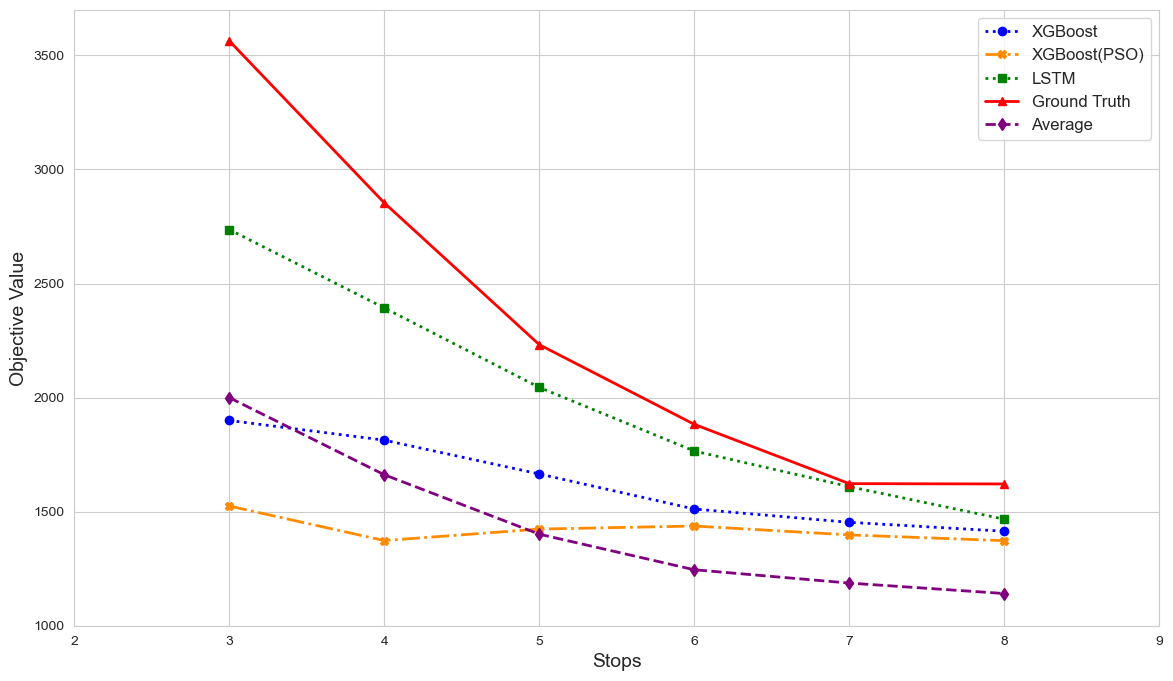

In [ ]:
sns.set_style('whitegrid')
plt.figure(figsize=(14, 8))

# Increase line width and change line style
plt.plot(list(xg_objectives.keys()), list(xg_objectives.values()), label='XGBoost', color='blue', marker='o', linewidth=2, linestyle=':')
plt.plot(list(xg_m_objectives.keys()), list(xg_m_objectives.values()), label='XGBoost(PSO)', color='darkorange', marker='X', linewidth=2, linestyle='-.')
plt.plot(list(lstm_objectives.keys()), list(lstm_objectives.values()), label='LSTM', color='green', marker='s', linewidth=2, linestyle=':')
plt.plot(list(original_objective.keys()), list(original_objective.values()), label='Ground Truth', color='red', marker='^', linewidth=2, linestyle='-')
plt.plot(list(average_objective.keys()), list(average_objective.values()), label='Average', color='purple', marker='d', linewidth=2, linestyle='--')

# Customize the axes and title
plt.xlabel('Stops', fontsize=14)
plt.ylabel('Objective Value', fontsize=14)
#plt.title('Simulation of objective values for different number of stops', fontsize=16, fontweight='bold')

# Set the limits if needed
plt.ylim(1000, 3700)
plt.xlim(2, 9)

# Customize the legend
plt.legend(frameon=True, loc='best', fontsize=12)

plt.savefig('Simulation of objective values for different number of stops', dpi=300)

# Show the plot
plt.show()

# Optimization of alternative station approach

In [ ]:
# LSTM
s_0_ls_ts= list(distance_df_lstm_ts['Station ID']) #[0,814, 138, 36, 794, 157, 220, 789, 641]
s_1_ls_ts=list(lstm_reposition_ts.keys())


# Parameters
P_s,Q,U,K,C_s= 1,20,39,0.014,7
T_s_lstm_ts = lstm_reposition_ts #{814: 4.0, 138: 1.0, 36: 3.0, 794: 2.0, 157: 2.0, 220: 4.0, 789: 3.0, 641: -2}

M=1000
lambda_v=0.009

#Ground truth
s_0_or_ts= list(distance_df_or_ts['Station ID']) #[0,814, 138, 36, 794, 157, 220, 789, 641]
s_1_or_ts=list(original_reposition_ts.keys())

# Parameters
P_s,Q,U,K,C_s= 1,20,39,0.014,7
T_s_or_ts = original_reposition_ts #{814: 4.0, 138: 1.0, 36: 3.0, 794: 2.0, 157: 2.0, 220: 4.0, 789: 3.0, 641: -2}
M=1000
lambda_v=0.009


lstm_optimization_3_ts = routing_optimization(s_0_ls_ts,s_1_ls_ts,T_s_lstm_ts,distance_matrix_lstm_ts,a_3)  # optimization for 3 stops
lstm_optimization_4_ts = routing_optimization(s_0_ls_ts,s_1_ls_ts,T_s_lstm_ts,distance_matrix_lstm_ts,a_4)  # optimization for 4 stops
lstm_optimization_5_ts = routing_optimization(s_0_ls_ts,s_1_ls_ts,T_s_lstm_ts,distance_matrix_lstm_ts,a_5)  # optimization for 5 stops

original_optimization_3_ts = routing_optimization(s_0_or_ts,s_1_or_ts,T_s_or_ts,distance_matrix_or_ts, a_3)
original_optimization_4_ts = routing_optimization(s_0_or_ts,s_1_or_ts,T_s_or_ts,distance_matrix_or_ts, a_4)
original_optimization_5_ts = routing_optimization(s_0_or_ts,s_1_or_ts,T_s_or_ts,distance_matrix_or_ts, a_5)
original_optimization_6_ts = routing_optimization(s_0_or_ts,s_1_or_ts,T_s_or_ts,distance_matrix_or_ts, a_6)
original_optimization_7_ts = routing_optimization(s_0_or_ts,s_1_or_ts,T_s_or_ts,distance_matrix_or_ts, a_7)
original_optimization_8_ts = routing_optimization(s_0_or_ts,s_1_or_ts,T_s_or_ts,distance_matrix_or_ts, a_8)





Discarded solution information
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-6300U CPU @ 2.40GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 123 rows, 57 columns and 244 nonzeros
Model fingerprint: 0xd7430eb7
Model has 44 quadratic objective terms
Variable types: 1 continuous, 56 integer (19 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [8e+01, 2e+02]
  QObjective range [8e+01, 8e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
Found heuristic solution: objective 1161.8328600
Presolve removed 118 rows and 49 columns
Presolve time: 0.01s
Presolved: 5 rows, 8 columns, 15 nonzeros
Presolved model has 4 quadratic objective terms
Variable types: 0 continuous, 8 integer (3 binary)

Root relaxation: objective 6.524695e+02, 10 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node  

Model fingerprint: 0x25950918
Model has 132 quadratic objective terms
Variable types: 1 continuous, 100 integer (34 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [8e+01, 3e+02]
  QObjective range [8e+01, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
Found heuristic solution: objective 3311.7723400
Presolve removed 199 rows and 75 columns
Presolve time: 0.00s
Presolved: 28 rows, 26 columns, 86 nonzeros
Presolved model has 48 quadratic objective terms
Variable types: 0 continuous, 26 integer (12 binary)
Found heuristic solution: objective 3230.1120200

Root relaxation: objective 5.777352e+02, 31 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  577.73524    0   19 3230.11202  780.00000  75.9%     -    0s
H    0     0                    1572.2752400  780.00000  50.4

H   24    30                    1678.5853600  780.00000  53.5%   4.4    0s

Cutting planes:
  Implied bound: 10
  StrongCG: 2
  Mod-K: 2

Explored 1685 nodes (8940 simplex iterations) in 0.63 seconds (0.12 work units)
Thread count was 4 (of 4 available processors)

Solution count 6: 1678.59 1874.21 1913.21 ... 3503.54

Optimal solution found (tolerance 1.00e-04)
Best objective 1.678585360000e+03, best bound 1.678585360000e+03, gap 0.0000%
Optimized travel cost: 820.58536
Optimized penalty 1 (unsatisfied demand): 858.0
Optimized penalty 2 (regulation): 0.18
Discarded solution information
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-6300U CPU @ 2.40GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 451 rows, 189 columns and 959 nonzeros
Model fingerprint: 0x30c6a60a
Model has 300 quadratic objective terms
Variable types: 1 continuous, 188 integer (62 binary)
C

In [ ]:
lstm_display_3_ts=display_optimization(lstm_optimization_3_ts,s_0_ls_ts,'LSTM prediction with 3 stops', a_3)   # optimization for 3 stops
lstm_display_4_ts=display_optimization(lstm_optimization_4_ts,s_0_ls_ts,'LSTM prediction with 4 stops', a_4)   # optimization for 4 stops
lstm_display_5_ts=display_optimization(lstm_optimization_5_ts,s_0_ls_ts,'LSTM prediction with 5 stops', a_5)   # optimization for 5 stops

Using LSTM prediction with 3 stops for optimization
Objective Value: 824.9130800000001
Optimal sequence of nodes with stops: [(0, 1), (640, 2), (0, 3)]
Number of bikes added or removed at each stop in the optimal solution:
At station 0, stop 1: 3.0 bikes were removed.
At station 640, stop 2: 3.0 bikes were added.
At station 0, stop 3: No bikes were added or removed.
Using LSTM prediction with 4 stops for optimization
Objective Value: 792.2752400000002
Optimal sequence of nodes with stops: [(0, 1), (808, 2), (640, 3), (0, 4)]
Number of bikes added or removed at each stop in the optimal solution:
At station 0, stop 1: 4.0 bikes were removed.
At station 808, stop 2: 1.0 bikes were added.
At station 640, stop 3: 3.0 bikes were added.
At station 0, stop 4: No bikes were added or removed.
Using LSTM prediction with 5 stops for optimization
Objective Value: 798.6374000000001
Optimal sequence of nodes with stops: [(0, 1), (808, 2), (640, 3), (808, 4), (0, 5)]
Number of bikes added or removed a

In [ ]:
original_display_3_ts=display_optimization(original_optimization_3_ts,s_0_or_ts,'Groud truth with 5 stops',a_3)
original_display_4_ts=display_optimization(original_optimization_4_ts,s_0_or_ts,'Groud truth with 5 stops',a_4)
original_display_5_ts=display_optimization(original_optimization_5_ts,s_0_or_ts,'Groud truth with 5 stops',a_5)
original_display_6_ts=display_optimization(original_optimization_6_ts,s_0_or_ts,'Groud truth with 6 stops',a_6)
original_display_7_ts=display_optimization(original_optimization_7_ts,s_0_or_ts,'Groud truth with 7 stops',a_7)
original_display_8_ts=display_optimization(original_optimization_8_ts,s_0_or_ts,'Groud truth with 8 stops',a_8)

Using Groud truth with 5 stops for optimization
Objective Value: 1829.68944
Optimal sequence of nodes with stops: [(0, 1), (808, 2), (0, 3)]
Number of bikes added or removed at each stop in the optimal solution:
At station 0, stop 1: 3.0 bikes were removed.
At station 808, stop 2: 3.0 bikes were added.
At station 0, stop 3: No bikes were added or removed.
Using Groud truth with 5 stops for optimization
Objective Value: 1572.2752400000002
Optimal sequence of nodes with stops: [(0, 1), (808, 2), (640, 3), (0, 4)]
Number of bikes added or removed at each stop in the optimal solution:
At station 0, stop 1: 6.0 bikes were removed.
At station 808, stop 2: 3.0 bikes were added.
At station 640, stop 3: 3.0 bikes were added.
At station 0, stop 4: No bikes were added or removed.
Using Groud truth with 5 stops for optimization
Objective Value: 1578.6374
Optimal sequence of nodes with stops: [(0, 1), (808, 2), (640, 3), (808, 4), (0, 5)]
Number of bikes added or removed at each stop in the optimal